# Proyectando el comportamiento de la soja

_Competencia Metadata 2019_  
_https://metadata.fundacionsadosky.org.ar/competition/11/_

## Objetivos
1. Lograr el mejor fit para la serie de retornos simples diarios $\frac{p_1 - p_0}{p_0}$. Serie desde la Fecha de Cierre del Concurso (FCC 29/9/2019) + 10 días hábiles.
2. Lograr la mejor proyección para el último valor de la serie contínua de la soja al fin del concurso. Cierra a la FCC + 10 días hábiles.
3. Lograr el mejor fit para la serie de retornos simples diarios de 4 semanas. Desde FCC - 10 días hábiles, hasta FCC + 10 días hábiles.

## Dataset oficial

[Dataset](https://drive.google.com/file/d/1r0DWiUIQ_N13HeervqrUhbV3TjUlEe4Q/view?usp=sharing) la información que contiene este archivo es hasta el día 29/8/2019. Por ende para calcular el score circunstancial se entiende que usted está proyectando hasta el día 12/9/2019. Esta información se irá actualizando todas las semanas hasta la última actualización que será el día 27/9/2019.

## Descripción

- `Fecha` Fecha de referencia para el precio.
- `Open` Precio de apertura del día.
- `High` Precio máximo del día.
- `Low` Precio mínimo del día.
- `Last` Precio último operado del día.
- `Cierre` Precio de ajuste del día. **Ésta es la serie a proyectarse.**
- `Aj.Dif.` Diferencia nominal respecto del día anterior.
- `Mon` Moneda de denominación del contrato.
- `Oi.Vol` Interés abierto del contrato.
- `Oi.Dif.` Diferencia del interés abierto respecto del día anterior.
- `Vol.Ope.` Volumen Operado medido en contratos.
- `Unidad` Unidad en que se miden los contratos.
- `DolarB.N.` Precio del dólar del Banco de la Nación Argentina.
- `DolarItau` Precio del dólar del Banco Itaú.
- `Diff.Sem` Diferencia Semanal.

## Métrica

La calificación de la solución propuesta se hace con el error absoluto medio ([MAE](https://en.wikipedia.org/wiki/Mean_absolute_error) por su sigla en inglés) y se calcula como el promedio de las diferencias (en valor absoluto) entre las respuestas enviadas y las correctas:

$$ MAE = \frac{1}{n} \sum_{j=1}^{n} |y_j - \hat{y_j} | $$

## Formato de respuesta

Debe enviarse un archivo en formato `csv` sin encabezado con 4 columnas y 20 filas.

- Primer columna debe contener al número de fila (int).
- Segunda columna debe contener las fechas correspondientes en formato "dd/mm/YYYY."
- Tercer columna debe contener los retornos (float).
- Cuarta columna debe contener el precio (cierre del día) del contrato (float).

Las filas 1 a 10 corresponden a FCC - 10 días hábiles y las filas 11 a 20 corresponden a la proyección futura.

## Exploración

In [1]:
%config InlineBackend.figure_format = 'retina'

import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import pyflux as pf
import seaborn as sns
import statsmodels.api as sm

warnings.simplefilter('ignore')
register_matplotlib_converters()

In [2]:
sns.set(rc={'figure.figsize': (12,8)})

In [3]:
data_dir = 'data'

In [4]:
date_parser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y 12:00:00 a.m.")
df = pd.read_csv(os.path.join(data_dir, 'datasetRofex2.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)

In [5]:
df.head()

,Id,Open,High,Low,Last,Cierre,Aj.Dif.,Mon.,OI.Vol.,OI.Dif.,Vol.Ope.,Unidad,DolarB.N.,DolarItau.,Dif.Sem
Fecha,,,,,,,,,,,,,,,
2004-01-05,1,0.0,0.0,0.0,0.0,221.0,13.0,D,0.0,0.0,0,TONS,2.920,2.905,-221.0
2004-01-06,2,0.0,0.0,0.0,0.0,221.0,0.0,D,0.0,0.0,0,TONS,2.880,2.870,-221.0
2004-01-07,3,0.0,0.0,0.0,0.0,219.0,-2.0,D,0.0,0.0,0,TONS,2.865,2.882,-219.0
2004-01-08,4,0.0,0.0,0.0,0.0,220.0,1.0,D,0.0,0.0,0,TONS,2.887,2.884,-220.0
2004-01-09,5,0.0,0.0,0.0,0.0,220.0,0.0,D,0.0,0.0,0,TONS,2.892,2.900,-220.0


Empezamos con un plot del precio de cierre en cada día.

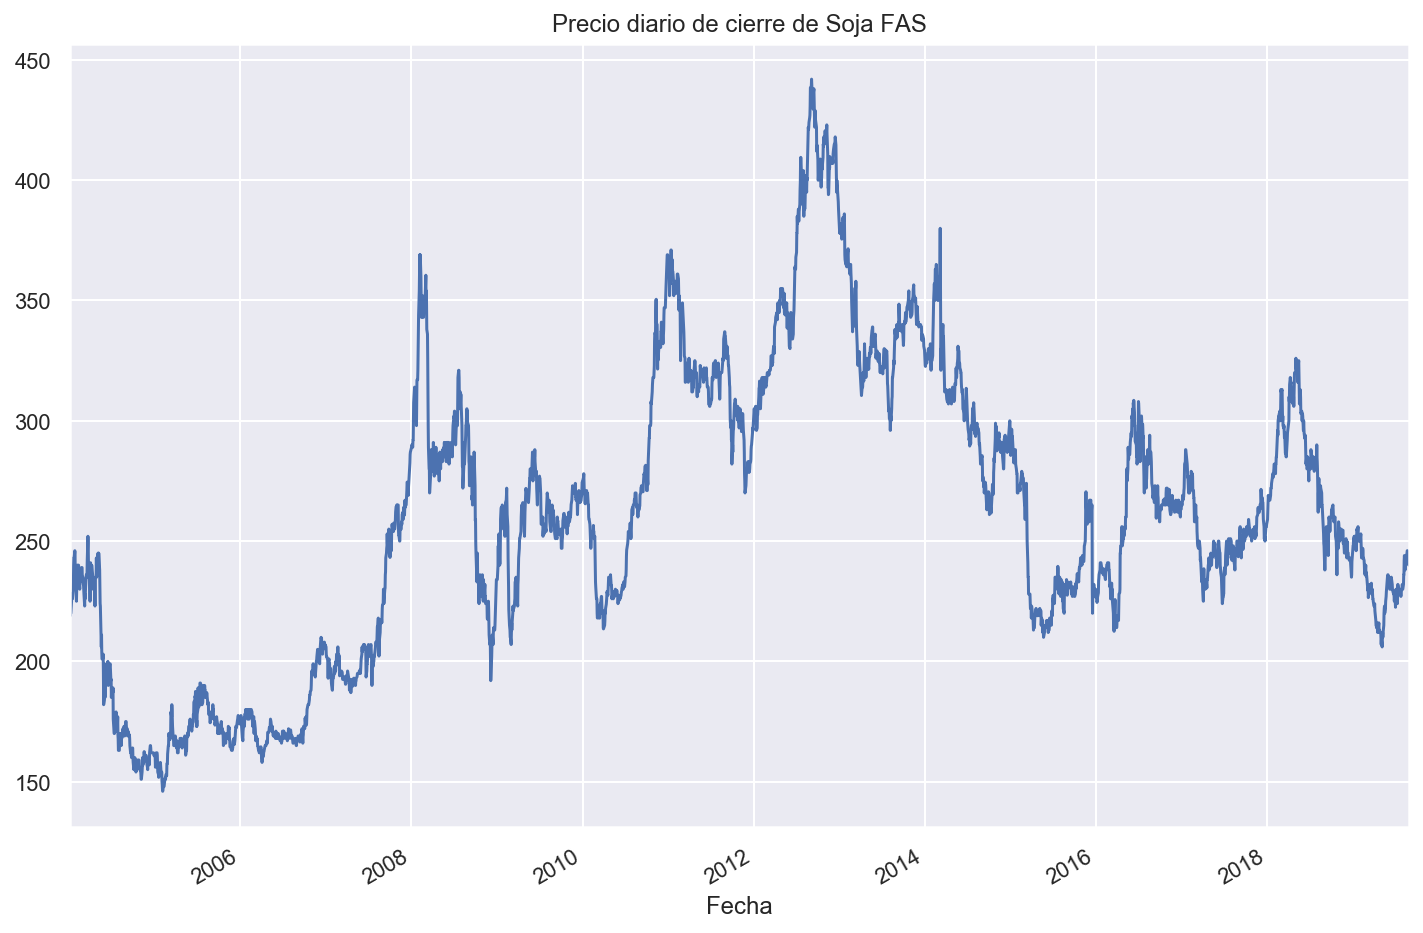

In [6]:
df['Cierre'].plot(title='Precio diario de cierre de Soja FAS');

El gráfico sugiere que se trata de una serie no [estacionaria](https://es.wikipedia.org/wiki/Proceso_estacionario), con un *trend* marcado. Podemos confirmar esto con un gáfico de [autocorrelación](https://otexts.com/fpp2/autocorrelation.html). Más aún, con el plot de [autocorrelacion parcial](https://es.wikipedia.org/wiki/Función_de_autocorrelación_parcial), podemos ver que la maxima autocorrelacion esta en el primer lag.

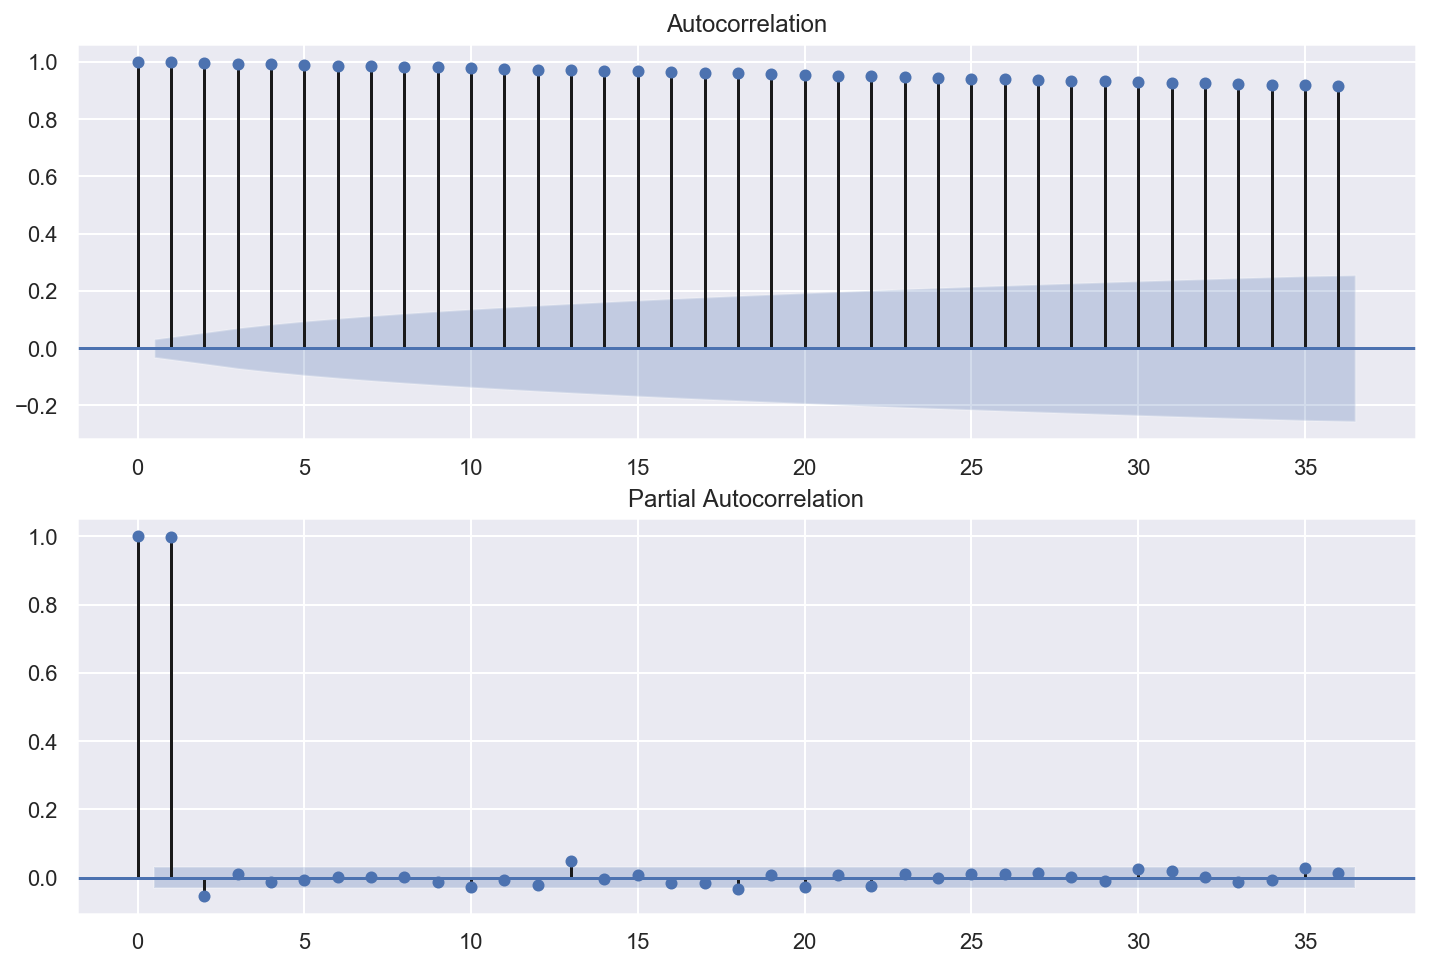

In [7]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['Cierre'], ax=ax1)
sm.graphics.tsa.plot_pacf(df['Cierre'], ax=ax2);

Si la serie fuera estacionaria, uno esperaría que la autocorrelación decreciera rápidamente al aumentar el *lag*, pero esto no es así. Nuestro objetivo, sin embargo, no es predecir el precio de cierre sino el retorno diario, que es (casi) la serie diferenciada. Veamos la autocorrelación de estos retornos.

In [8]:
df['retorno'] = df['Cierre'].pct_change()
df['log_retorno'] = np.log(df['Cierre'] / df['Cierre'].shift(1))
retornos = df['retorno'].dropna()

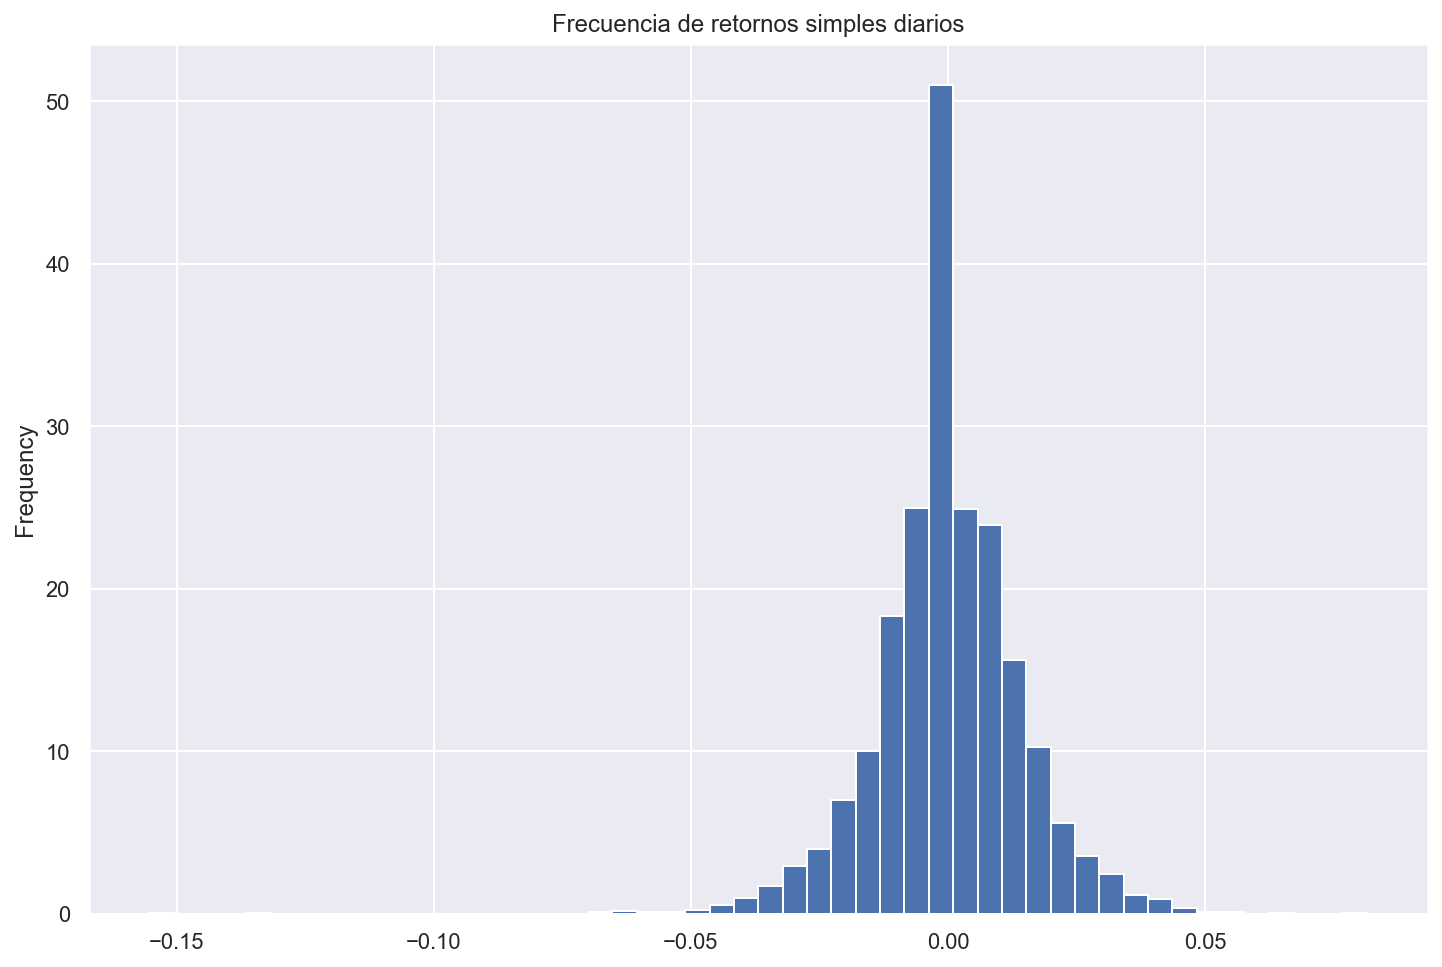

In [9]:
df['retorno'].plot(kind='hist', bins=50, title='Frecuencia de retornos simples diarios', density=True);

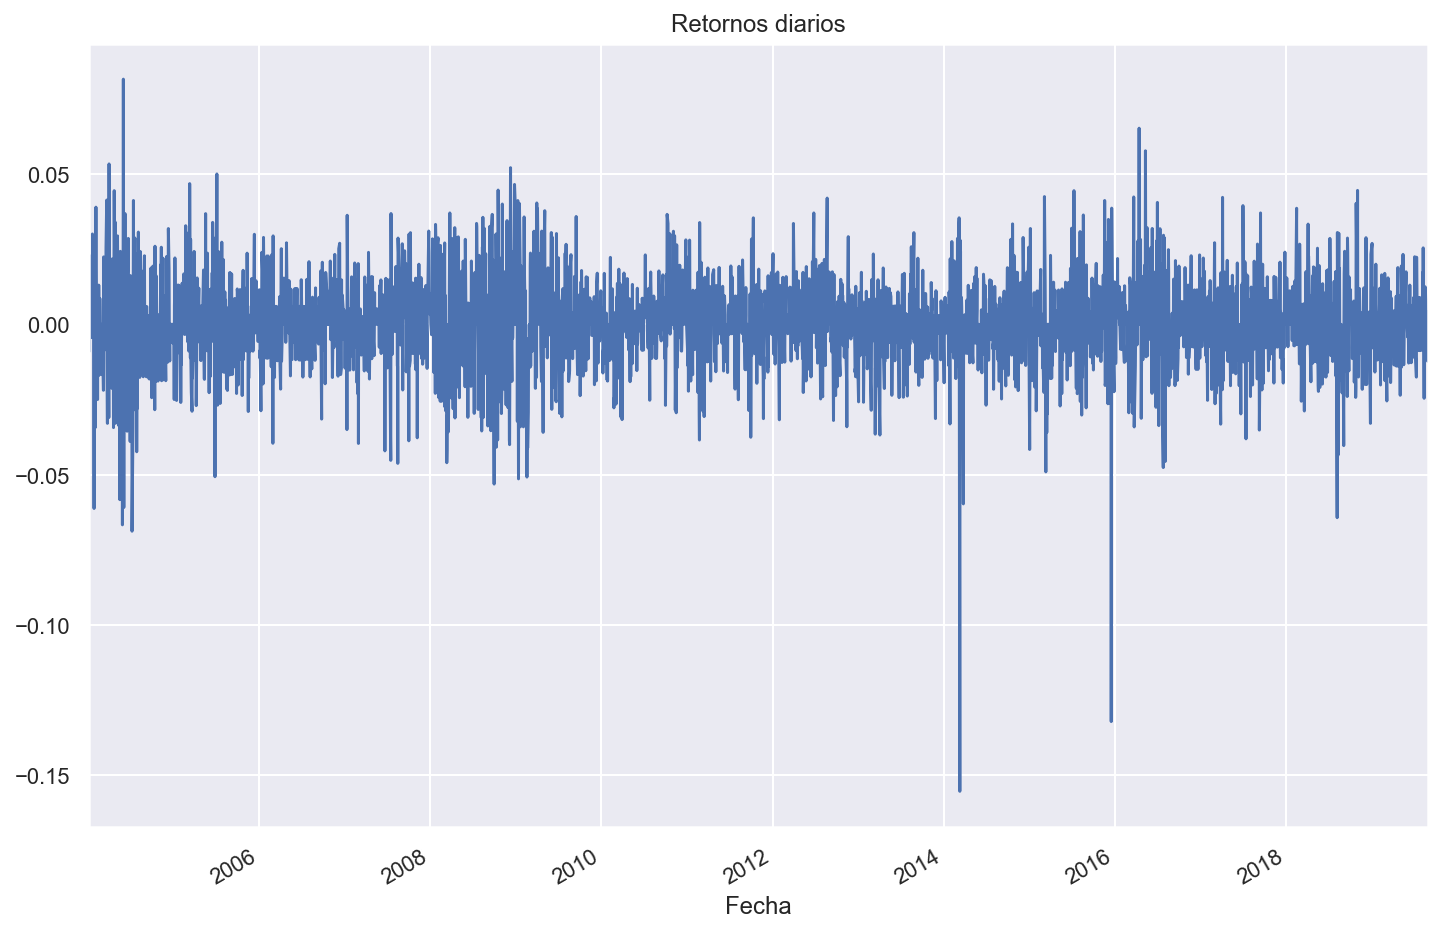

In [10]:
df['retorno'].dropna().plot(title='Retornos diarios');

Repetimos los plots de autocorrelación para la serie de retornos diarios.

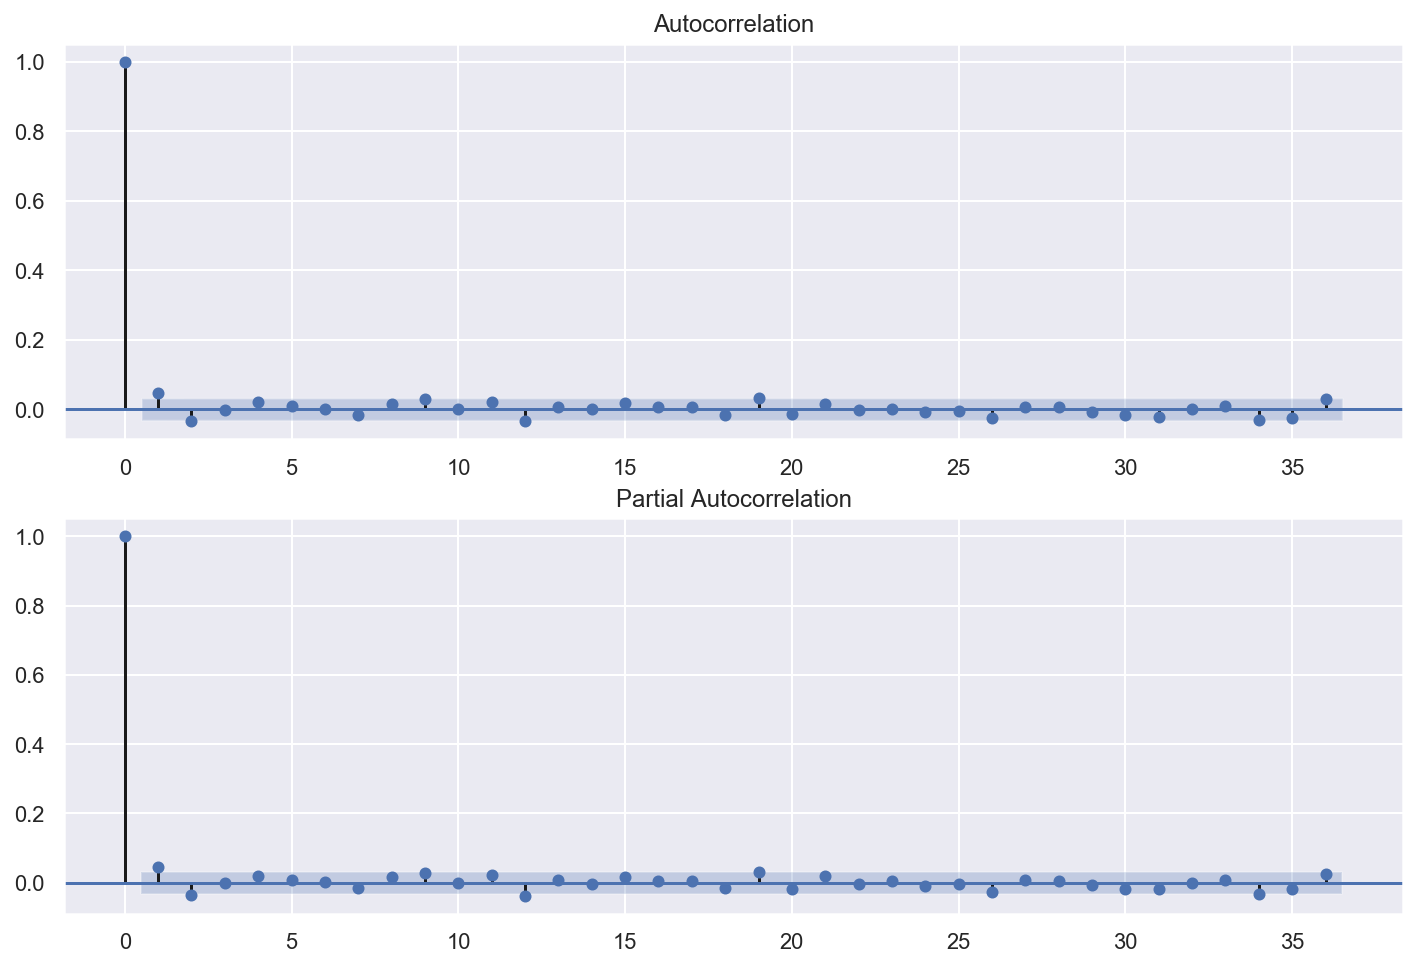

In [11]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(df['retorno'].dropna(), ax=ax1)
sm.graphics.tsa.plot_pacf(df['retorno'].dropna(), ax=ax2);

Se ve claramente que al tomar retornos, la autocorrelación baja muy rápido al aumentar el lag, lo que nos dice que estamos en presencia de un proceso más estacionario. 

## Método ARIMA

Nuestra herramienta principal para la predicción de los retornos será el método ARIMA, que explicamos brevemente a continuación.

[ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average) (*Autoregressive integrated moving average*) es un modelo aplicado a series de tiempo que considera al valor actual de la serie como una regresión sobre valores previos y al error de regresión como una combinación lineal de errores previos. Más precisamente, si la serie la notamos $\{Y_t\}_{t \in \mathbb{N}}$, el valor a tiempo $t$ se modela por 

$$Y_t = \phi_0 + \sum_{i=1}^{p}{\phi_i Y_{t-i}} + \sum_{i=1}^{q}{\theta_i \varepsilon_{t-i}} + \varepsilon_t$$

donde los $\varepsilon_i$ con $i\neq t$ son errores de regresión, $\varepsilon_t$ es [ruido blanco](https://es.wikipedia.org/wiki/Ruido_blanco) y los coeficientes $\phi_i$ y $\theta_i$ se ajustan típicamente a través de métodos estadísticos. La cantidad de pasos en el pasado que se consideran forma un par de hiperparámetros del modelo (los números $p$ y $q$), con un tercero (generalmente notado $d$) que determina cuántas veces diferenciar la serie antes de aplicarle lo anterior. Todo esto da un método $ARIMA(p,d,q)$. En nuestro caso tomamos $d=0$ porque aplicamos el método a los retornos, que ya son lo suficientemente estacionarios. Si lo quisiéramos aplicar al precio de cierre tomaríamos $d=1$ para diferenciarlo, obteniendo una serie muy similar a los retornos pero a otra escala (porque en cada paso no estaríamos diviendo por el precio del día anterior).

Una vez obtenido el fit por ARIMA, usamos el método GARCH para hacernos una idea de la volatilidad de los residuos y corroborar que ésta es (aproximadamente) constante. 

[GARCH](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity) (*Generalized autoregressive conditional heteroskedasticity*) es otro modelo aplicado a series de tiempo para describir la varianza del error entre el valor observado y el que se había previsto (en nuestro caso, el término $\varepsilon_t$ que se consideraba ruido blanco). Típicamente esta varianza se escribe como combinación lineal de sus valores previos, como en un método ARMA (la $i$ de ARIMA refiere al proceso de diferenciar la serie para volverla estacionaria).

Para decidir qué hiperparámetros de ARIMA tomar usamos el método auto_arima de la librería *pmdarima*, que ajusta el método para diferentes valores de $p$ y $q$, los compara usando el [criterio de información de Akaike](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike) y el [criterio de información bayesiano](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_bayesiano) y arroja el mejor fit.

In [12]:
import pmdarima as pm

stepwise_fit = pm.auto_arima(retornos, start_p=1, start_q=1,
                             max_p=3, max_q=3,
                             start_P=0, seasonal=False,
                             d=None, trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)  

Fit ARIMA: order=(1, 0, 1); AIC=-21815.846, BIC=-21790.820, Fit time=0.271 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-21808.796, BIC=-21796.283, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-21814.693, BIC=-21795.923, Fit time=0.043 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-21815.281, BIC=-21796.511, Fit time=0.019 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-21815.650, BIC=-21784.367, Fit time=0.503 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 2); AIC=-21814.593, BIC=-21777.053, Fit time=0.717 seconds
Total fit time: 1.743 seconds


In [13]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 3853
Model:                     ARMA(1, 1)   Log Likelihood               10911.923
Method:                       css-mle   S.D. of innovations              0.014
Date:                Fri, 27 Sep 2019   AIC                         -21815.846
Time:                        11:50:16   BIC                         -21790.820
Sample:                             0   HQIC                        -21806.958
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.525      0.599      -0.000       0.001
ar.L1.y       -0.3447      0.191     -1.806      0.071      -0.719       0.029
ma.L1.y        0.3950      0.186      2.118      0.034       0.030       0.760
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9013           +0.0000j            2.9013            0.5000
MA.1           -2.5318           +0.0000j            2.5318            0.5000
-----------------------------------------------------------------------------
"""

In [14]:
#ARIMA
p = 1
q = 1
#GARCH
r = 1
s = 1
#Número de predicciones a futuro
n = 13

In [15]:
model_arima = sm.tsa.statespace.SARIMAX(retornos.values,order=(p,0,q), seasonal=False)

In [16]:
fit = model_arima.fit()

In [17]:
mean_prediction = fit.forecast(n)

Graficamos las predicciones de ARIMA, primero en los retornos y después en el precio de cierre.

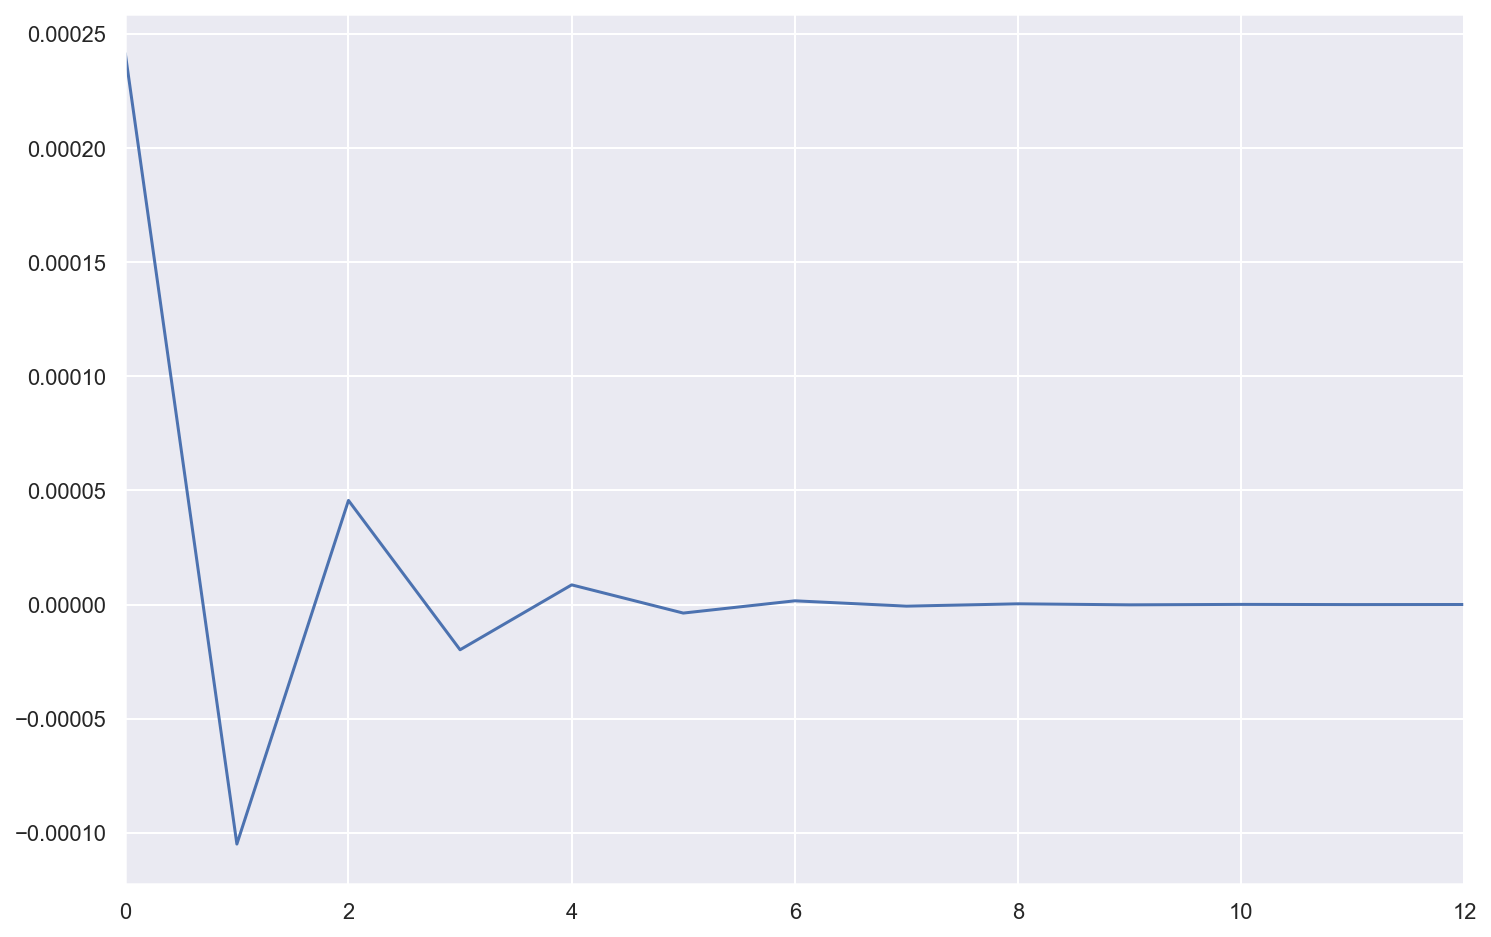

In [18]:
pd.Series(mean_prediction).plot();

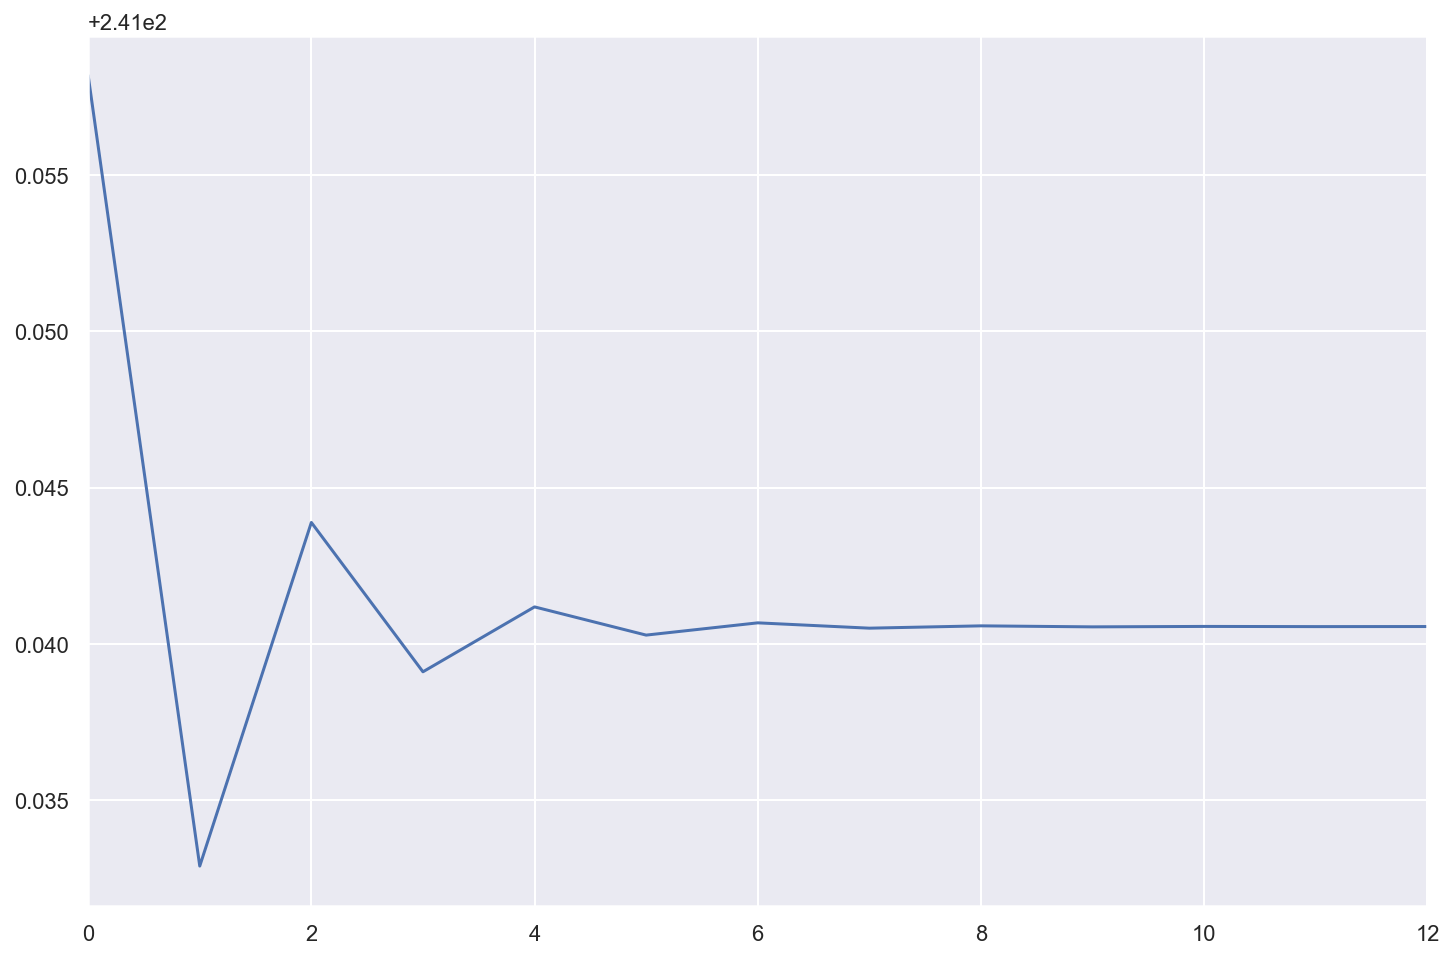

In [19]:
pd.Series((1 + mean_prediction).cumprod() * df['Cierre'][-1]).plot();

In [20]:
residuos = fit.resid

In [21]:
model_garch = pf.GARCH(residuos,r,s)
x = model_garch.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 11166.526                         
End Date: 3852                                          AIC: -22325.0521                                  
Number of observations: 3852                            BIC: -22300.0267                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

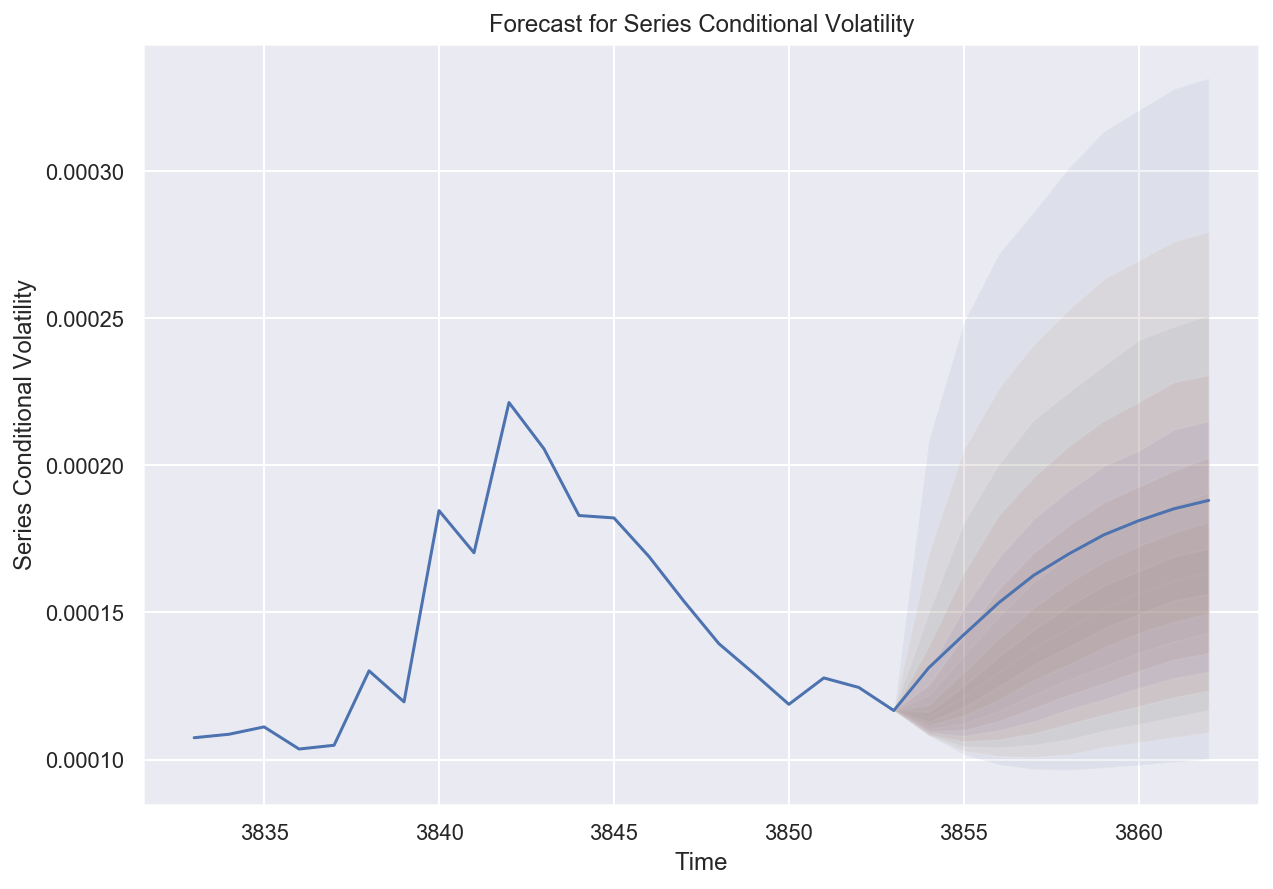

In [22]:
model_garch.plot_predict(h=10)

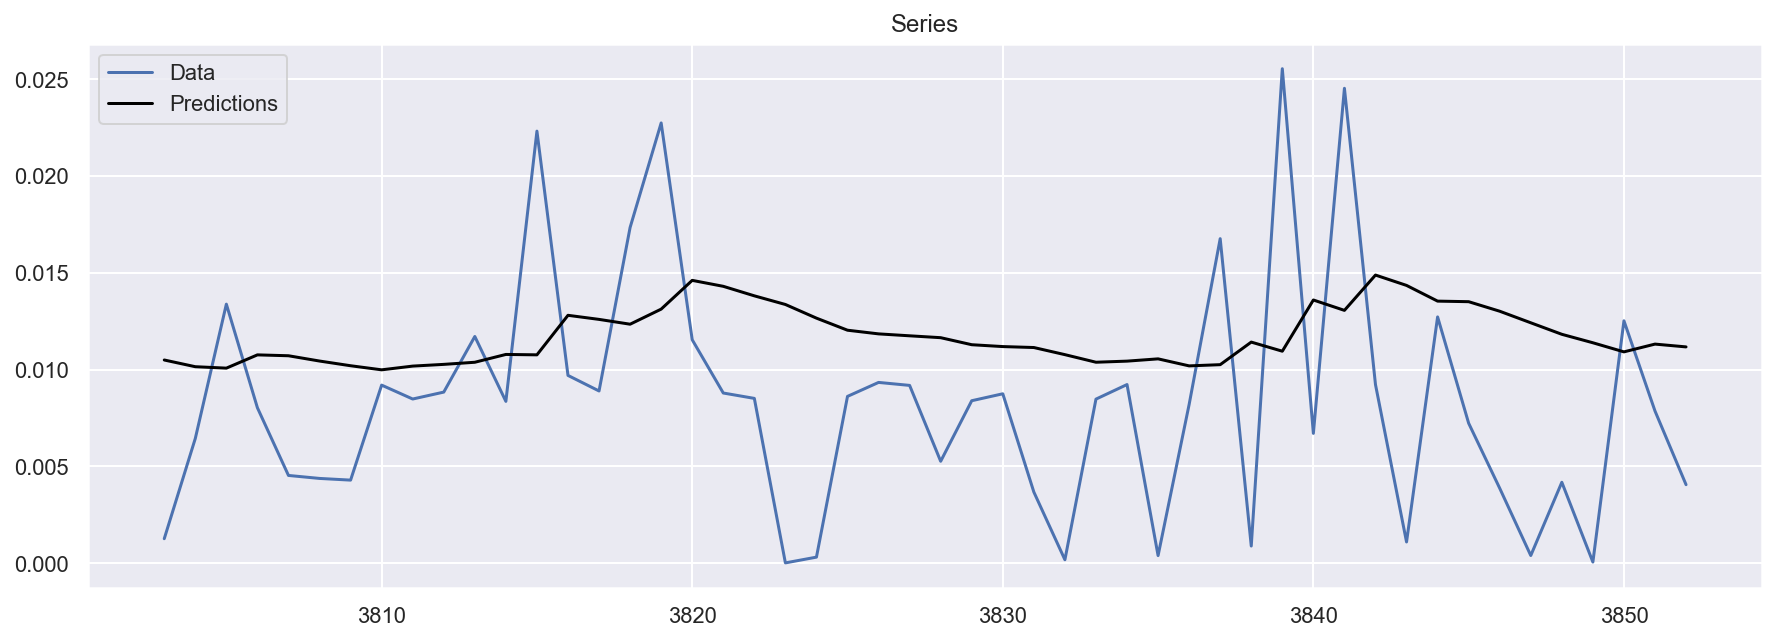

In [23]:
model_garch.plot_predict_is(h=50,figsize=(15,5))

Comparamos ahora las predicciones obtenidas con los valores reales del período 30/08 - 17/09, los 13 días hábiles inmediatamente posteriores a nuestra serie.

In [24]:
futuros = pd.read_csv(os.path.join(data_dir, 'Futuros.csv'),
                 parse_dates=['Fecha'],
                 index_col='Fecha',
                 date_parser=date_parser)
futuros = futuros.append(df.loc['2019-08-29'])
futuros.sort_index(inplace=True)
futuros['retorno'] = futuros['Cierre'].pct_change()

In [25]:
daily_returns_futuros = futuros['Cierre'].pct_change().dropna()

In [26]:
#Error en los retornos usando ARIMA
diff_arima = (daily_returns_futuros.reset_index()['Cierre'].values - mean_prediction[:13])
diff_abs_arima = np.abs(diff_arima)
np.sum(diff_abs_arima)/13

0.007445347252650231

In [27]:
#Error en los retornos si se predice con el último valor
daily_returns_futuros.abs().sum()/13

0.007413082079339508

In [28]:
#Error en el precio de cierre usando sólo ARIMA
predicted_close_arima = (1 + mean_prediction).cumprod() * df['Cierre'][-1]
diff_close_arima = (futuros.reset_index()['Cierre'][1:].values - predicted_close_arima[:13])
diff_close_arima_abs = np.abs(diff_close_arima)
np.sum(diff_close_arima_abs)/13

1.8628235423134727

In [29]:
#Error en el precio de cierre si se predice con el último valor
diff_close_last_value = (futuros.reset_index()['Cierre'][1:].values - df['Cierre'][-1])
diff_close_last_value_abs = np.abs(diff_close_last_value)
np.sum(diff_close_last_value_abs)/13

1.8461538461538463

Al aplicar ARIMA sobre la serie de retornos el resultado es prácticamente cero, lo cual es esperable ya que la idea es que el método capture la [media condicional](https://en.wikipedia.org/wiki/Conditional_expectation) del proceso, y se ve claramente que ésta es (aproximadamente) cero en el gráfico. 

En estas condiciones, la predicción a la que llegamos no es muy diferente a tomar el último valor de precio de cierre. De hecho, si comparamos el error absoluto medio (MAE) de ambas predicciones para las dos semanas posteriores a nuestros datos, la predicción que toma el último valor es un poco más precisa que ARIMA en este caso. Vemos también que GARCH nos da un valor de la volatilidad condicional estable, como buscábamos.

#### Últimos siete meses

Hacemos ahora las mismas predicciones pero restringiendo nuestros datos (la serie de tiempo de retornos) a los últimos siete meses. Esto se corresponde al período febrero-agosto, complementario a la siembra en Argentina (septiembre-enero). 

In [30]:
df_seasonal_Feb_Aug = df_seasonal_Feb_Aug = df.loc[(df.index.month >1) & (df.index.month <9)]
df_seasonal_Feb_Aug['year'] = df_seasonal_Feb_Aug.index.year

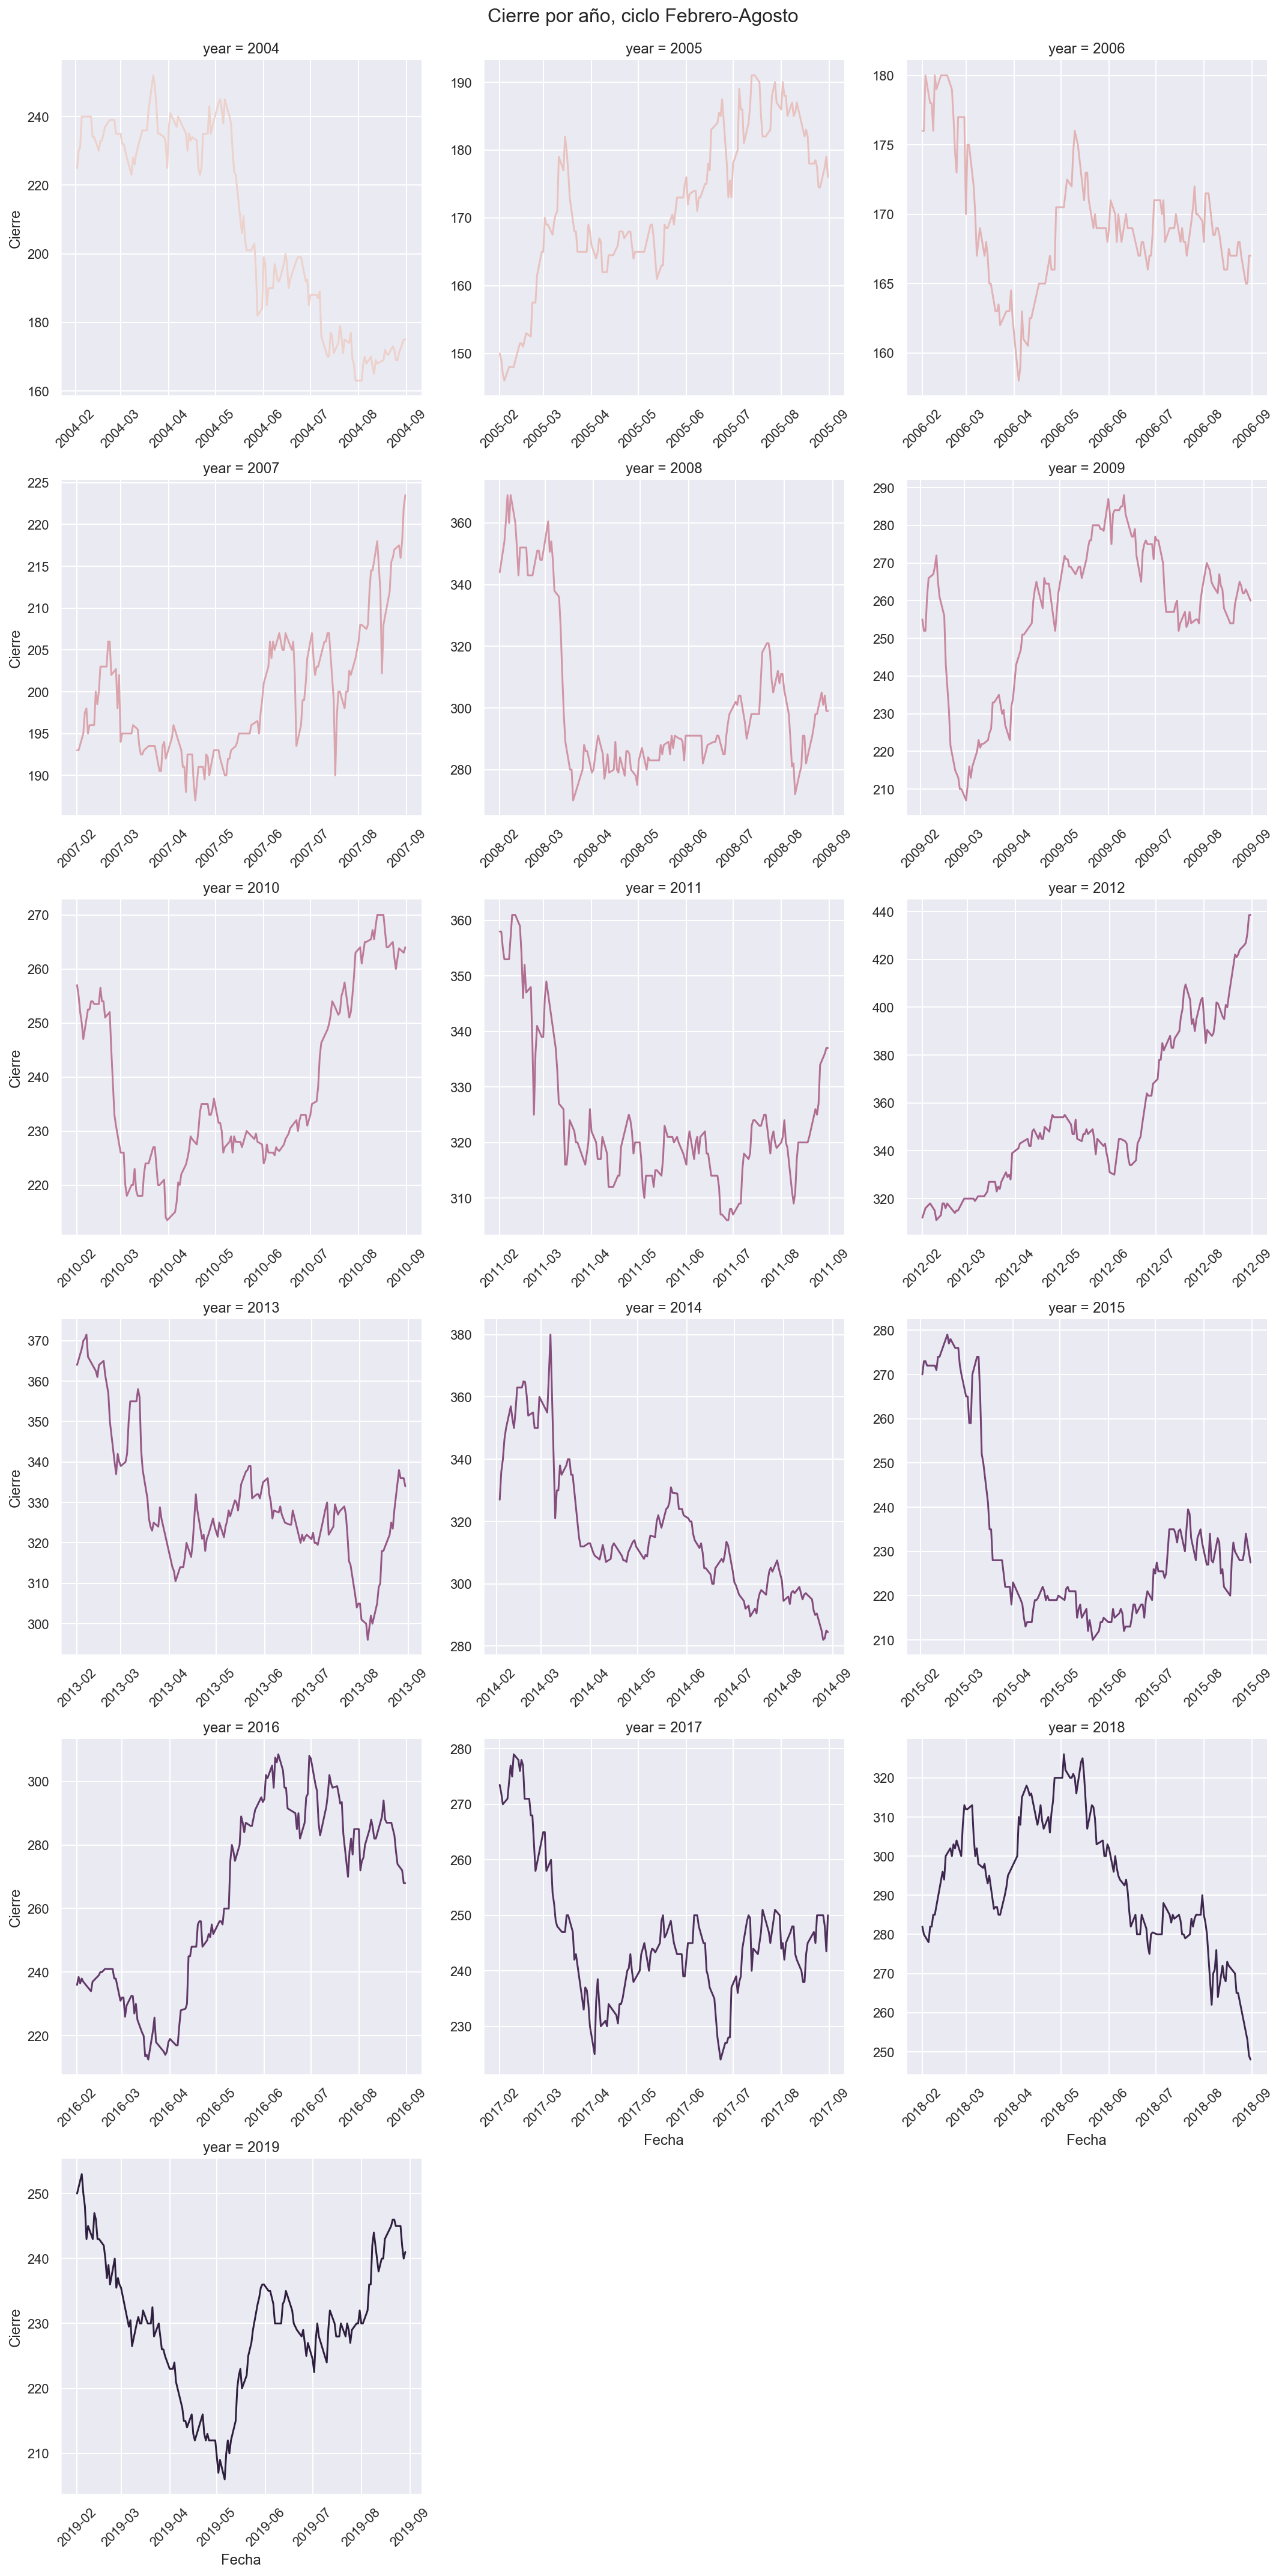

In [31]:
g = sns.relplot(x='Fecha', y='Cierre', col='year', hue='year',
            facet_kws=dict(sharey=False, sharex=False), col_wrap=3, legend=False,
            kind='line', data=df_seasonal_Feb_Aug.reset_index())

for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=45)

g.fig.suptitle("Cierre por año, ciclo Febrero-Agosto", size=16)
g.fig.subplots_adjust(top=.96, hspace=0.25);

In [32]:
retornos_seven_months = df.last('7M')['retorno'].dropna()

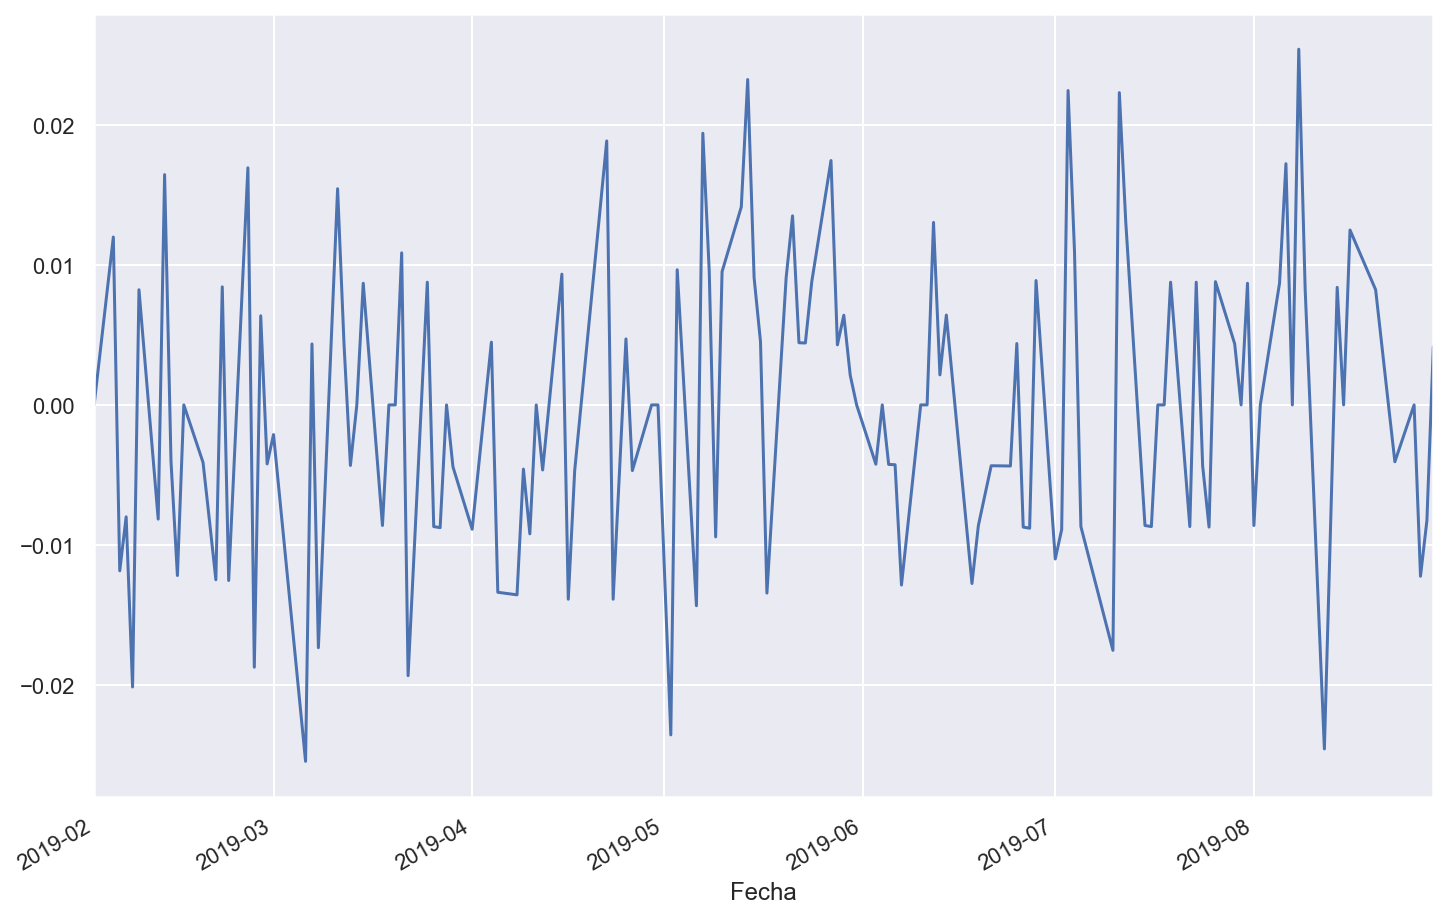

In [33]:
retornos_seven_months.plot();

In [34]:
model_arima_seven_months = sm.tsa.statespace.SARIMAX(retornos_seven_months.values,order=(p,0,q), seasonal=False)

In [35]:
fit_seven_months = model_arima_seven_months.fit()

In [36]:
mean_prediction_seven_months = fit_seven_months.forecast(n)

Nuevamente graficamos las predicciones de ARIMA de los retornos y el precio de cierre.

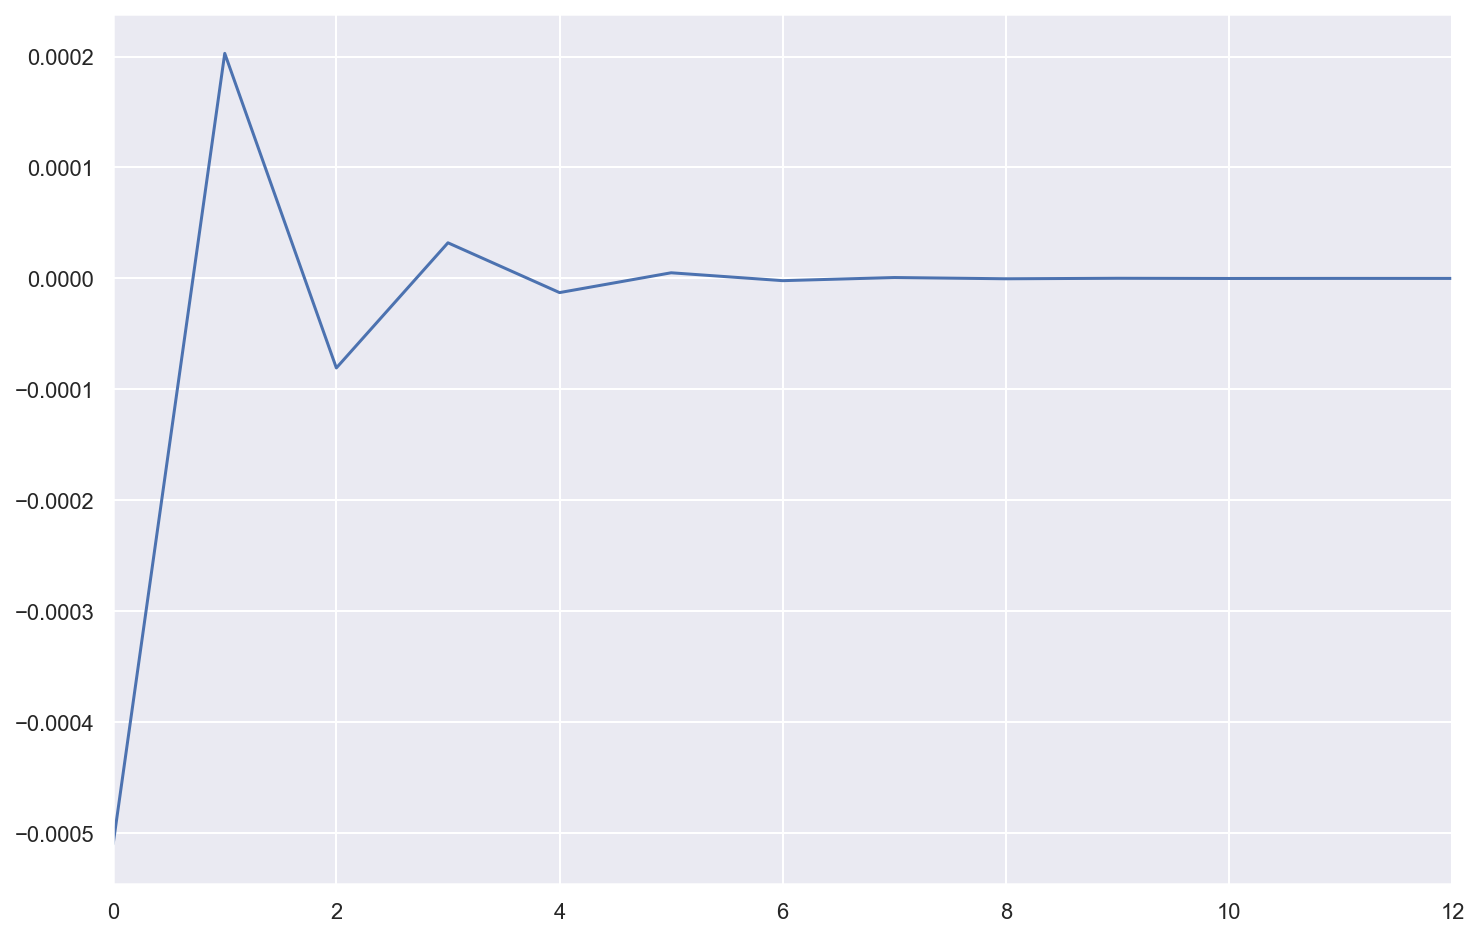

In [37]:
pd.Series(mean_prediction_seven_months).plot();

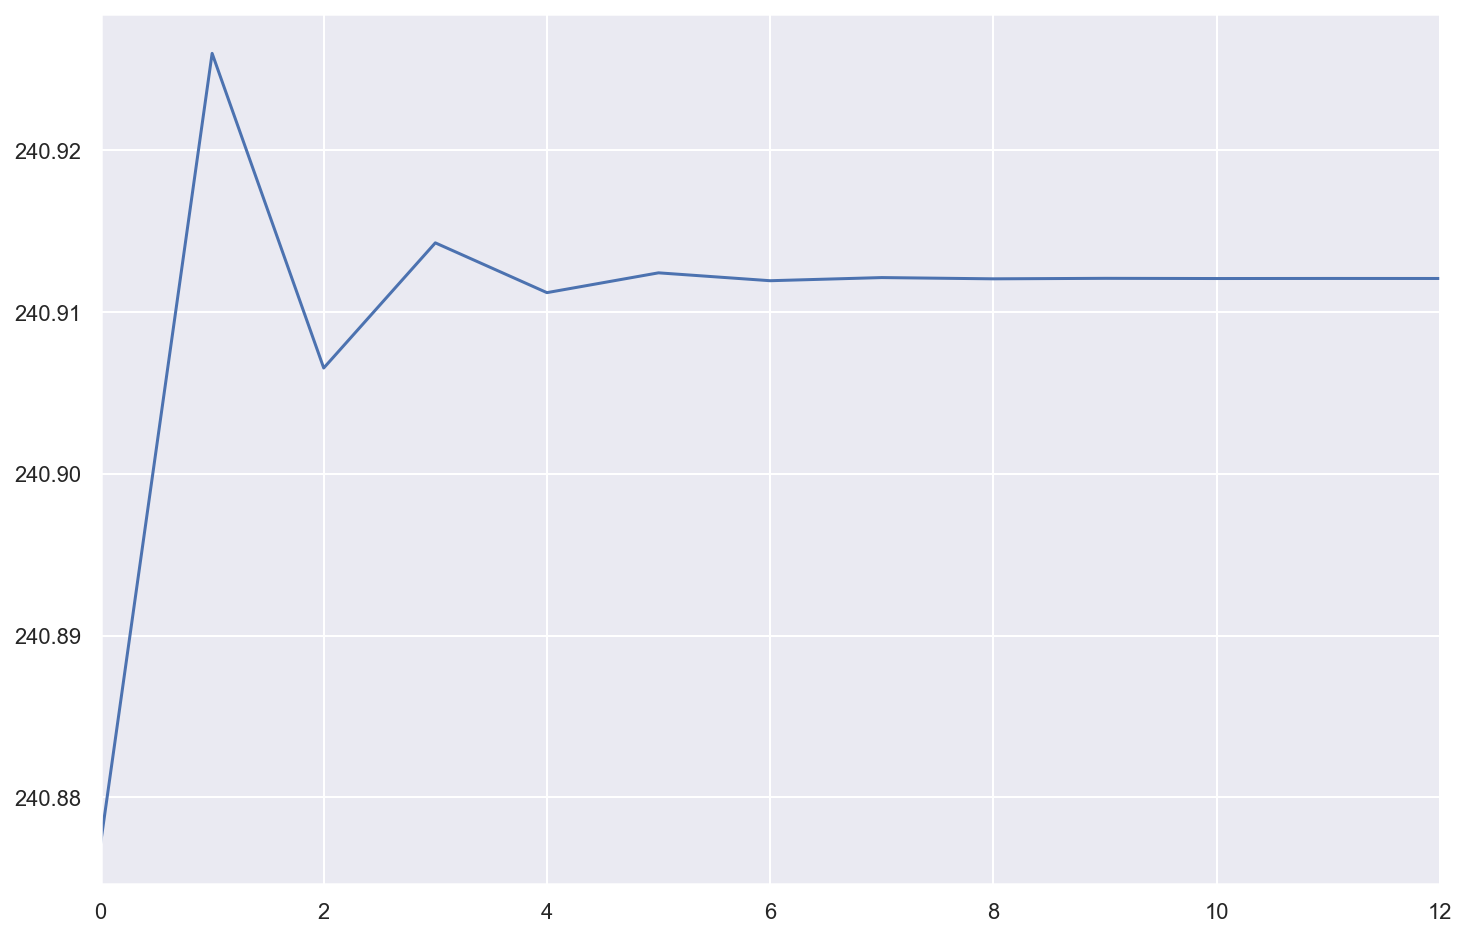

In [38]:
pd.Series((1 + mean_prediction_seven_months).cumprod() * df['Cierre'][-1]).plot();

In [39]:
residuos_seven_months = fit.resid

In [40]:
model_garch_seven_months = pf.GARCH(residuos_seven_months,r,s)
x = model_garch_seven_months.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: 11166.526                         
End Date: 3852                                          AIC: -22325.0521                                  
Number of observations: 3852                            BIC: -22300.0267                                  
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             0.0                                                              
q(1)                                 

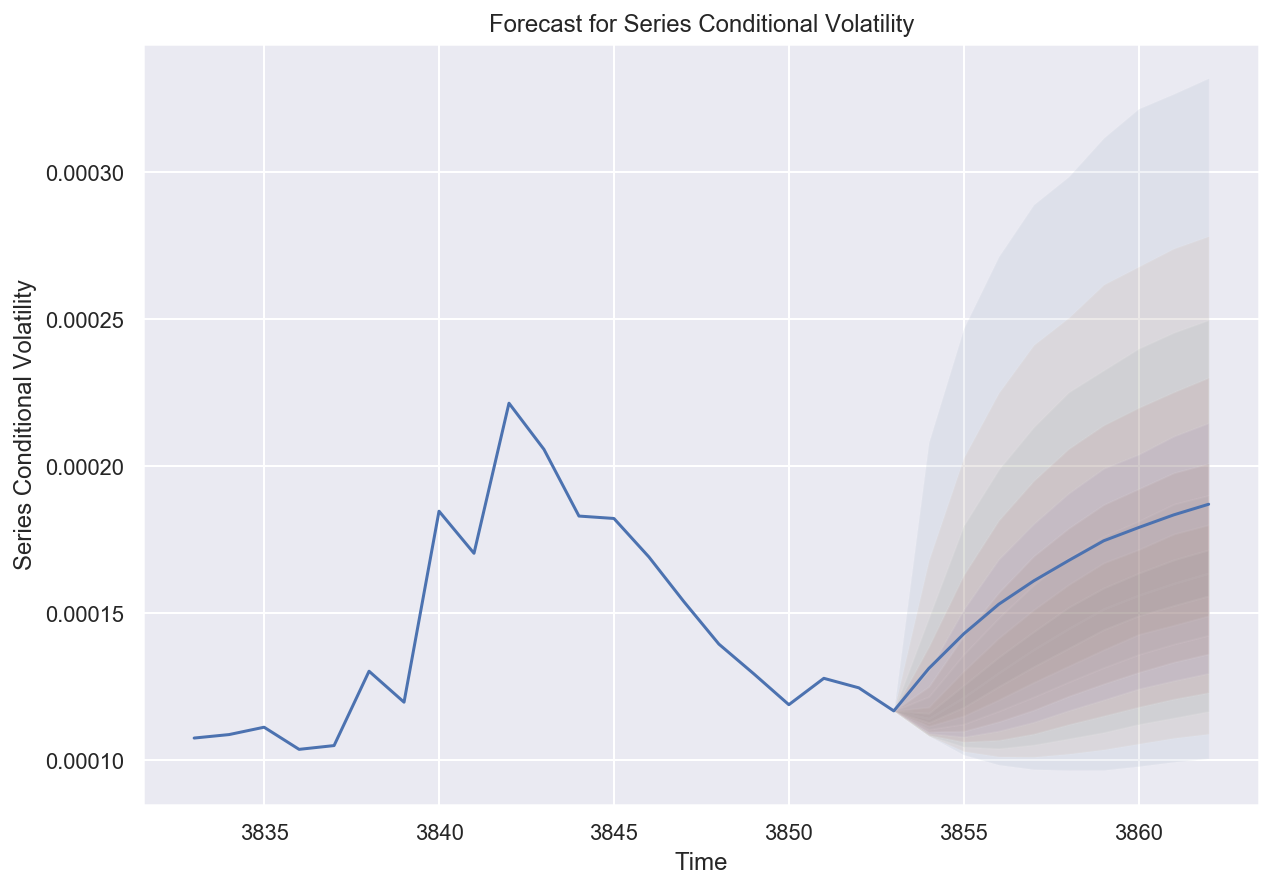

In [41]:
model_garch_seven_months.plot_predict(h=10)

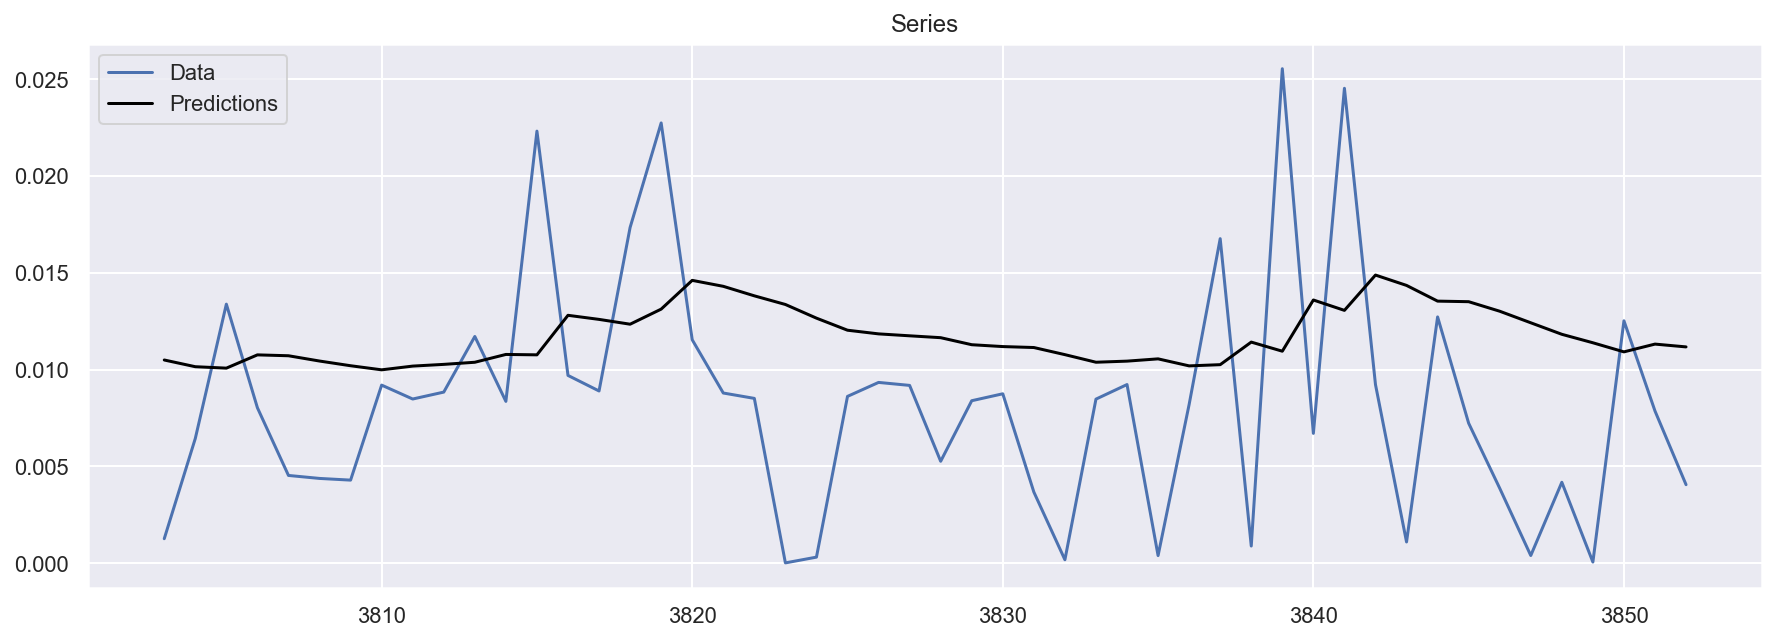

In [42]:
model_garch_seven_months.plot_predict_is(h=50,figsize=(15,5))

In [43]:
#Error en los retornos usando ARIMA
diff_arima = (daily_returns_futuros.reset_index()['Cierre'].values - mean_prediction_seven_months[:13])
diff_abs_arima = np.abs(diff_arima)
np.sum(diff_abs_arima)/13

0.007381932379505365

In [44]:
#Error en los retornos si se predice con el último valor
daily_returns_futuros.abs().sum()/13

0.007413082079339508

In [45]:
#Error en el precio de cierre usando ARIMA
predicted_close_arima_seven_months = (1 + mean_prediction_seven_months).cumprod() * df['Cierre'][-1]
diff_close_arima = (futuros.reset_index()['Cierre'][1:].values - predicted_close_arima_seven_months[:13])
diff_close_arima_abs = np.abs(diff_close_arima)
np.sum(diff_close_arima_abs)/13

1.8237270390904012

In [46]:
#Error en el precio de cierre si se predice con el último valor
diff_close_last_value = (futuros.reset_index()['Cierre'][1:].values - df['Cierre'][-1])
diff_close_last_value_abs = np.abs(diff_close_last_value)
np.sum(diff_close_last_value_abs)/13

1.8461538461538463

### Facebook Prophet

Entre los métodos alternativos que probamos, se encuentra la libreria [Prophet](https://facebook.github.io/prophet/) de Facebook, que implementa un modelo de decomposición aditiva con tres componentes: trend ($g(t)$), estacionalidad ($s(t)$) y feriados (_holidays_, $h(t)$).

$$y(t) = g(t) + s(t) + h(t) + \epsilon_t$$

Siendo $\epsilon_t$ un término de error que no ajusta el modelo. Este modelo es en esencia a un [modelo aditivo generalizado](https://es.wikipedia.org/wiki/Modelo_lineal_generalizado#Modelos_de_aditivos_generalizados) que utiliza el tiempo como regresor.  
Para más información, se puede consultar el [paper original](https://peerj.com/preprints/3190/).

In [47]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [48]:
data = pd.DataFrame({'ds': df.index, 'y': df['Cierre']})

prophet_model = Prophet(weekly_seasonality=False)
prophet_model.add_seasonality(name='bianual', period=182, fourier_order=5)
prophet_model.fit(data);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


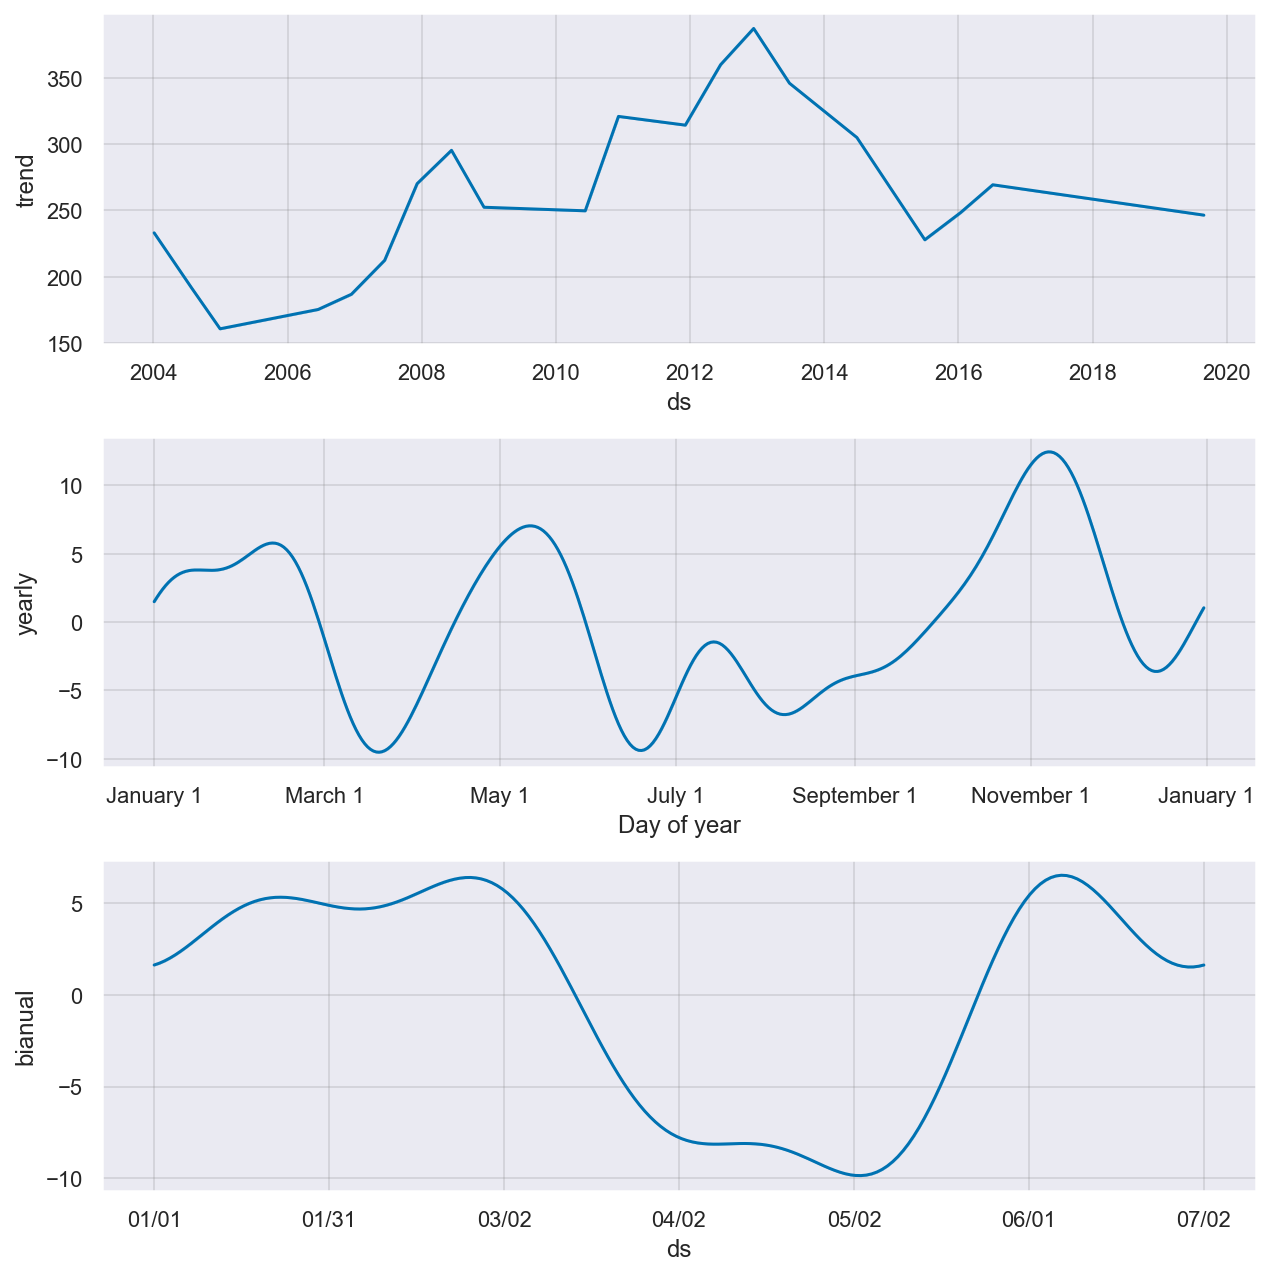

In [49]:
prophet_forecast = prophet_model.predict(data)
prophet_model.plot_components(prophet_forecast);

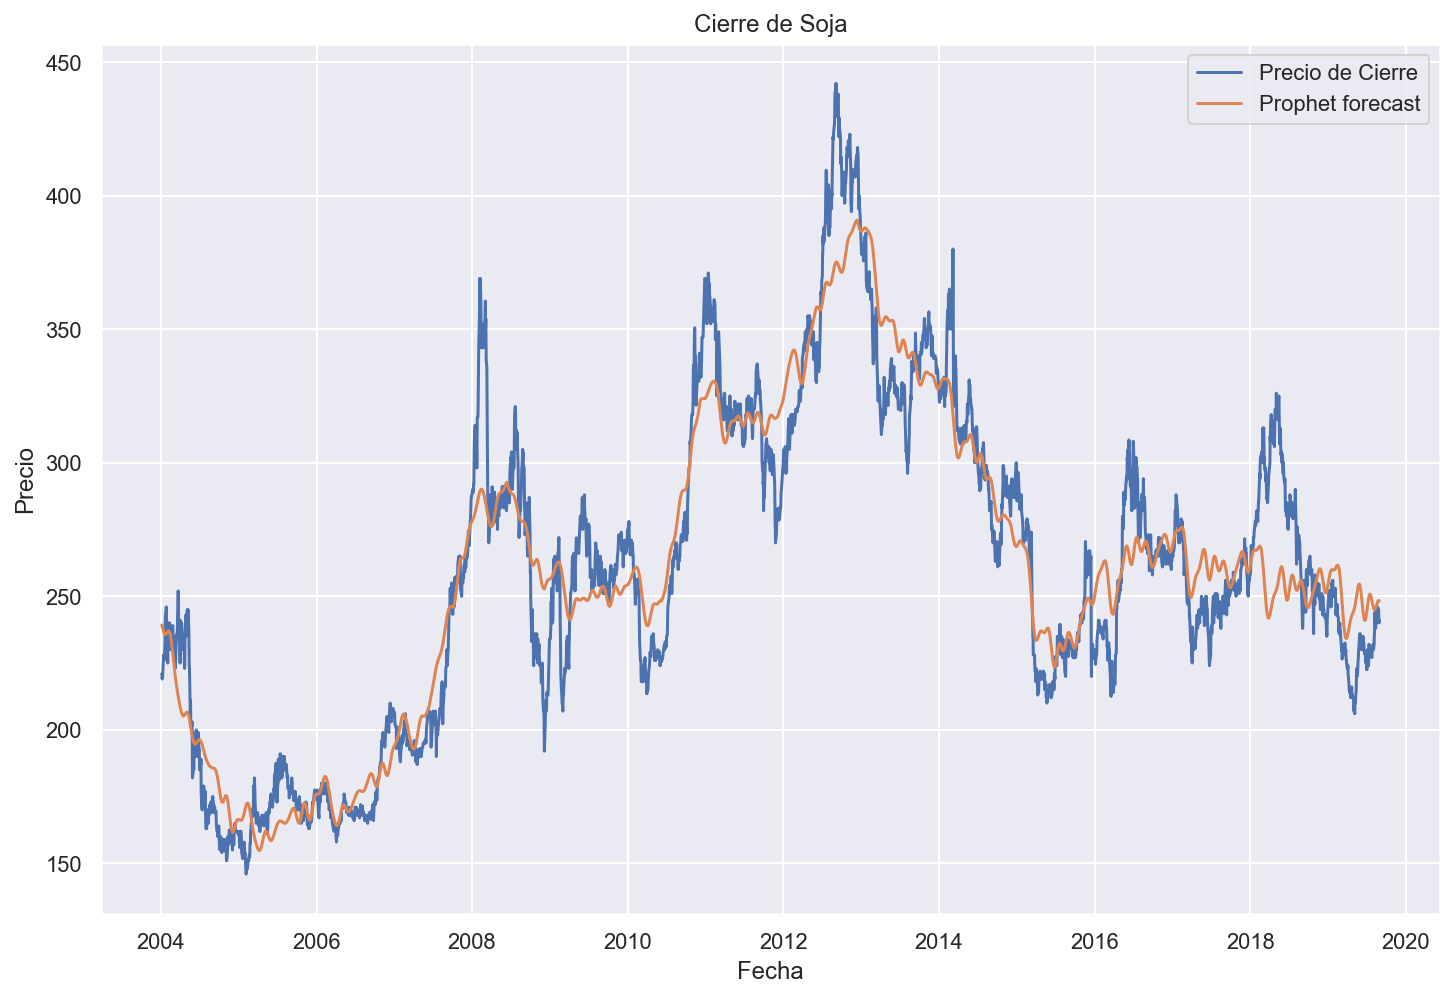

In [50]:
ax = sns.lineplot(x=df.index, y=df['Cierre'], label='Precio de Cierre')
sns.lineplot(y=prophet_forecast['yhat'], x=prophet_forecast['ds'], label='Prophet forecast', ax=ax)
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.set_title('Cierre de Soja');

In [51]:
test_periods = pd.DataFrame({'ds': futuros.index})
prophet_predictions = prophet_model.predict(test_periods)

In [52]:
prophet_predictions.set_index('ds', inplace=True)
prophet_predictions['retorno'] = prophet_predictions['yhat'].pct_change()

last = df.iloc[-1]['Cierre']
ret = (prophet_predictions['yhat'][0] - last)/ last
prophet_predictions['retorno'][0] = ret

In [53]:
prophet_mae = (prophet_predictions['retorno'] - futuros['retorno']).abs().sum() / (len(futuros) - 1)
print('Prophet forecast MAE =', prophet_mae)

Prophet forecast MAE = 0.008107070932185562


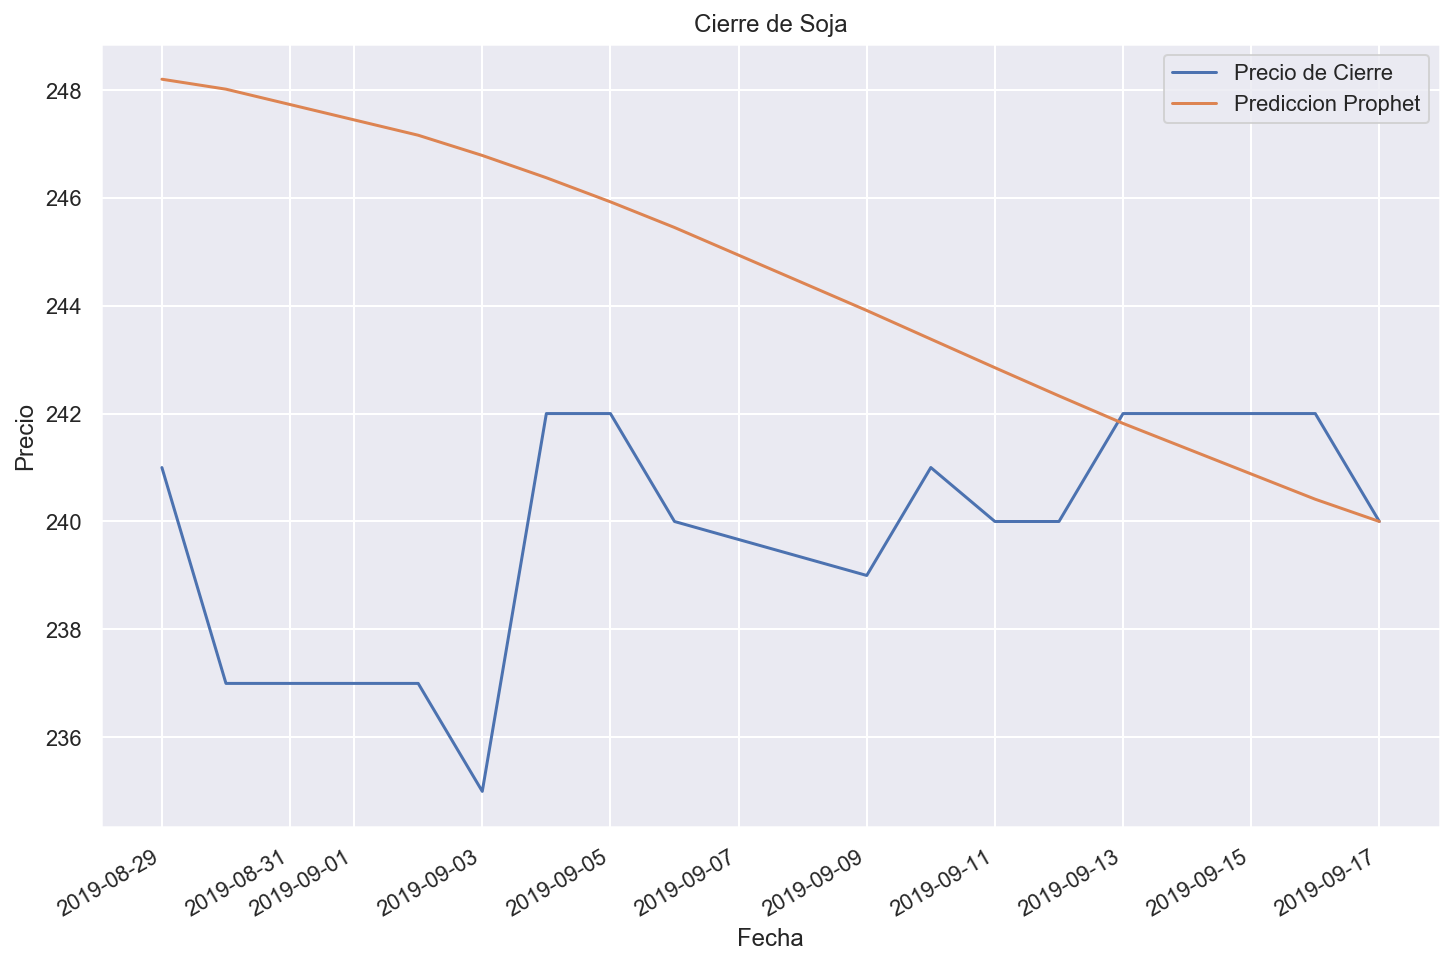

In [54]:
ax = sns.lineplot(x=futuros.index, y=futuros['Cierre'], label='Precio de Cierre')
sns.lineplot(y=prophet_predictions['yhat'], x=prophet_predictions.index, label='Prediccion Prophet', ax=ax)
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.figure.autofmt_xdate()
ax.set_title('Cierre de Soja');

### Autoregresiones Bayesianas

También probamos modelos autoregresivos Bayesianos, donde los coeficientes de los términos de la regresión se aproximan mediante [MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo).  
Hicimos uso del módulo te series temporales de la librería [PyMC3](https://docs.pymc.io/api/distributions/timeseries.html), una potente framework de modelado Bayesiano y programación probabilística.

In [55]:
import pymc3 as pm

#### $AR(1)$ sobre precio de cierre

Probamos inicialmente modelando la serie de precios como un proceso $AR(1)$:

$$p_t = \phi_1 p_{t-1} + \epsilon_t$$

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [phi_1]
Sampling 2 chains: 100%|██████████| 28000/28000 [00:10<00:00, 2715.45draws/s]
logp = -1.3735e+08, ||grad|| = 2.7465e+08: 100%|██████████| 4/4 [00:00<00:00, 461.17it/s]


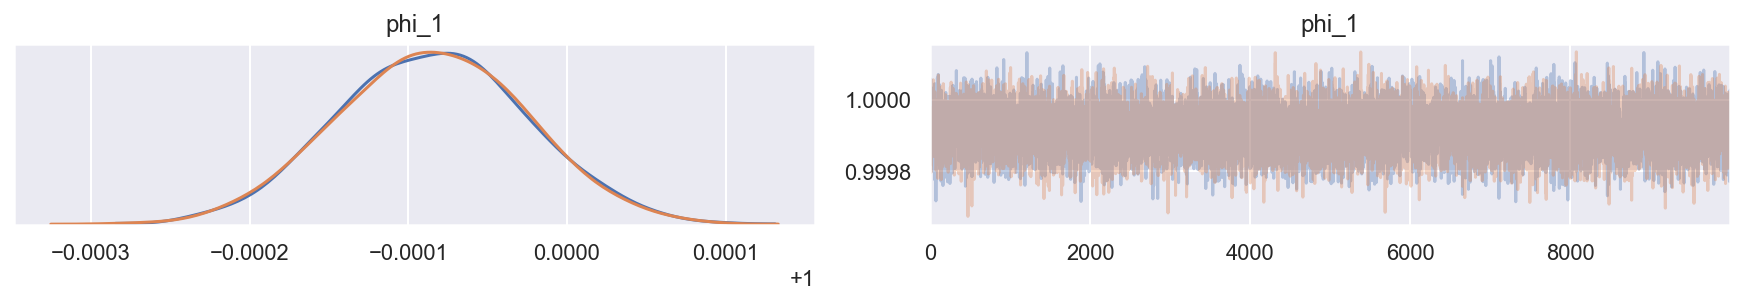

In [56]:
sigma = 1.0

with pm.Model() as ar1:
    phi1 = pm.Normal('phi_1', mu=0, sigma=sigma)
    data = pm.AR('p', phi1, observed=df['Cierre'])
    trace = pm.sample(10000, tune=4000)
    map_ar1 = pm.find_MAP()

pm.traceplot(trace);

Como era esperable según lo visto en los plots de autocorrelación, el modelo asigna un valor cercano a $1$ para el coeficiente del primer término de lag.  
A continuación, hacemos un plot de la predicción del modelo para los próximos 100 días.

In [57]:
phi1_hat = map_ar1['phi_1']

In [58]:
steps = 100

last_day = df.index[-1]
last_price = df.loc[last_day, 'Cierre']
forecast_period = pd.date_range(start=last_day + pd.DateOffset(1), periods=steps, freq='B')

forecast = np.repeat(phi1_hat, steps).cumprod()
forecasts = pd.DataFrame({'forecast': last_price * forecast}, index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

In [59]:
def plot_forecast(forecast_df, steps=100):
    ax = sns.lineplot(x=forecast_df.index[-2*steps:-steps], y=forecast_df['Cierre'][-2*steps:-steps], label='Precio de Cierre')
    sns.lineplot(x=forecast_df.index[-steps:], y=forecast_df['forecast'][-steps:], label='Predicción', ax=ax)
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Precio')
    ax.figure.autofmt_xdate()
    ax.set_title('Cierre de Soja');

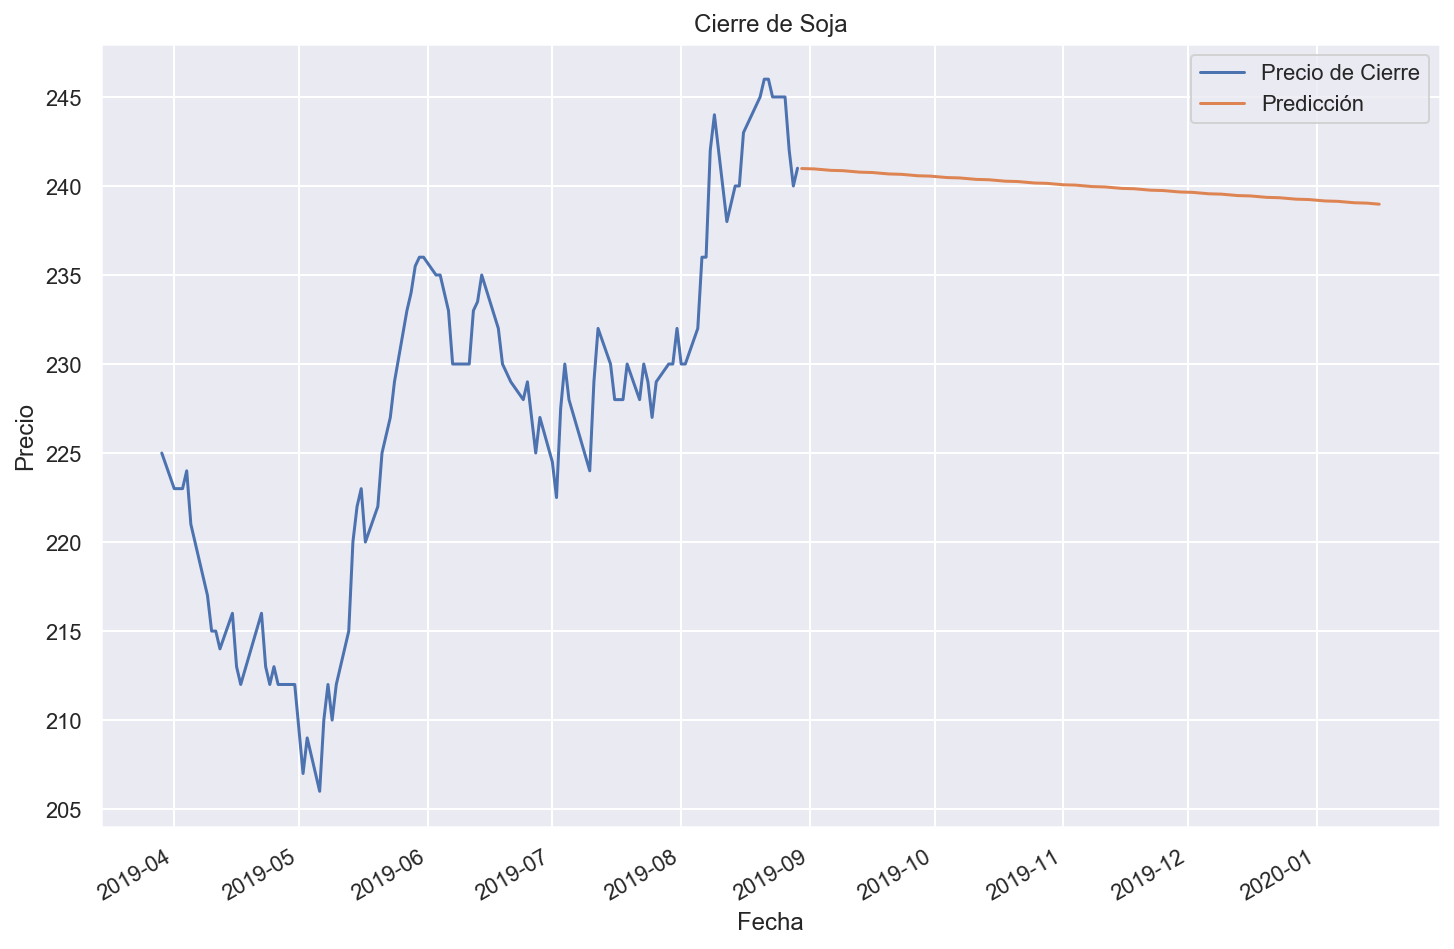

In [60]:
plot_forecast(forecast_df)

#### $AR(2)$ sobre precio de cierre

Probamos ahora un modelo $AR(2)$, sabiendo que la autocorrelación parcial con los lags de mayor orden es cercana a 0.

$$p_t = \phi_1 p_{t-1} + \phi_2 p_{t-2} + \epsilon_t$$

In [61]:
with pm.Model() as ar2:
    phi1 = pm.Normal('phi_1', mu=0, sigma=sigma)
    phi2 = pm.Normal('phi_2', mu=0, sigma=sigma)
    data = pm.AR('p', [phi1, phi2], observed=df['Cierre'])
    trace = pm.sample(10000, tune=4000)
    map_ar2 = pm.find_MAP()

pm.traceplot(trace);

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:NUTS: [phi_2, phi_1]
Sampling 2 chains:   5%|▍         | 1344/28000 [00:01<00:21, 1249.49draws/s]


RuntimeError: Chain 0 failed.

Vemos que el coeficiente del segundo término de lag es cercano a $0$, como era previsible. Veamos el plot de predicciones.

In [ ]:
phi1_hat = map_ar2['phi_1']
phi2_hat = map_ar2['phi_2']

In [ ]:
def ar2_process(steps, phis, last_prices):
    prices = last_prices.copy()

    for i in range(steps):
        last, second_last, *rest = prices
        next_price = phis[0] * last + phis[1] * second_last
        prices = [next_price] + prices
    
    return np.array(prices[:-2])[::-1]

In [ ]:
second_to_last_price = df['Cierre'][-2]
forecast = ar2_process(steps, [phi1_hat, phi2_hat], [last_price, second_to_last_price])
forecasts = pd.DataFrame({'forecast': forecast},
                         index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

In [ ]:
plot_forecast(forecast_df)

#### $AR(1)$ sobre retornos

Probamos a continuación modelando los retornos como un proceso $AR(1)$

$$r_t = \phi_1 r_{t-1} + \epsilon_t$$

In [ ]:
with pm.Model() as ar1_ret:
    phi1 = pm.Normal('phi_1', mu=0, sigma=sigma)
    data = pm.AR('r', phi1, observed=df['retorno'].dropna())
    trace = pm.sample(10000, tune=4000)
    map_ar1_ret = pm.find_MAP()

pm.traceplot(trace);

Como era esperable, el coeficiente del primer lag de los retornos es aproximadamente $0$

In [ ]:
phi1_hat_ret = map_ar1_ret['phi_1']

In [ ]:
last_return = df['retorno'][-1]
forecast = (np.repeat(phi1_hat_ret, steps) * last_return + 1).cumprod()
forecasts = pd.DataFrame({'forecast': last_price * forecast}, index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

In [ ]:
plot_forecast(forecast_df)

### Bayesian Structural Time Series

Otro enfoque más moderno en el análisis de series temporales es el que desarrolan Scott y Varian en el paper [_Predicting the Present with Bayesian Structural Time Series_](http://people.ischool.berkeley.edu/~hal/Papers/2013/pred-present-with-bsts.pdf) (2014).  
A grandes rasgos, el modelo es un ensamble de predictores: combina la descomposición de series en diferentes variables de estado (tendencia, estacionalidad) con componentes regresivos.

Para la implementación, usamos [Tensorflow Probability](https://www.tensorflow.org/probability/), una librería para programación probabilística creada sobre [Tensorflow](https://www.tensorflow.org).

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

In [ ]:
tf.reset_default_graph()

trend = sts.LocalLinearTrend(observed_time_series=df['Cierre'])
seasonal = tfp.sts.Seasonal(num_seasons=33,
                            num_steps_per_season=123,
                            observed_time_series=df['Cierre'])
model = sts.Sum([trend, seasonal], observed_time_series=df['Cierre'])

with tf.variable_scope('sts_elbo', reuse=tf.AUTO_REUSE):
    elbo_loss, variational_posteriors = tfp.sts.build_factored_variational_loss(
        model, observed_time_series=df['Cierre'])

In [ ]:
steps = 200

train_vi = tf.train.AdamOptimizer(0.1).minimize(elbo_loss)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(steps):
        _, elbo_ = sess.run((train_vi, elbo_loss))
        if i % 20 == 0:
            print("step {} -ELBO {}".format(i, elbo_))

        samples = sess.run({k: q.sample(50)
                                    for k, q in variational_posteriors.items()})

In [ ]:
for param in model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(samples[param.name], axis=0),
                                np.std(samples[param.name], axis=0)))

In [ ]:
price_dist = tfp.sts.forecast(model,
                              observed_time_series=df['Cierre'],
                              parameter_samples=samples,
                              num_steps_forecast=steps)

In [ ]:
num_samples = 10

with tf.Session() as sess:
    price_mean, price_scale, price_forecast_samples = sess.run(
        (price_dist.mean()[..., 0], price_dist.stddev()[..., 0],
         price_dist.sample(num_samples)[..., 0]))

In [ ]:
last_day = df.index[-1]
forecast_period = pd.date_range(start=last_day + pd.DateOffset(1), periods=steps, freq='B')

In [ ]:
forecasts = pd.DataFrame({'forecast': price_mean}, index=forecast_period)
forecast_df = df.append(forecasts, sort=True)

In [ ]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

ax = sns.lineplot(x=forecast_df.index, y=forecast_df['Cierre'], label='Precio de Cierre')
sns.lineplot(x=forecast_df.index, y=forecast_df['forecast'], ax=ax, label='Predicción BSTS')
ax.plot(forecast_period, price_forecast_samples.T, lw=1, color=c2, alpha=0.1);
ax.fill_between(forecast_period,
                price_mean - 2 * price_scale,
                price_mean + 2 * price_scale,
                color=c2,
                alpha=0.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio')
ax.figure.autofmt_xdate()
ax.set_title('Cierre de Soja');

La complejidad de este modelo hace que aqui lo estemos presentando como una [caja negra](https://en.wikipedia.org/wiki/Black_box). Aclarado esto, vemos que las predicciones de este modelo coinciden con los resultados vistos anteriormente: el mejor predictor del precio futuro es el último precio de cierre.